# Universidad de Buenos Aires
# Aprendizaje Profundo - TP1
# Cohorte 20 - 3er bimestre 2025


Este primer TP comienza la semana de la clase 2 y la ventana de entrega estará abierta hasta las **23hs del jueves 31 de julio (hora de Argentina)**. La resolución del TP es **individual**. Pueden utilizar los contenidos vistos en clase y otra bibliografía. Si se toman ideas de fuentes externas deben ser correctamente citadas incluyendo el correspondiente link o página de libro.

ESTE TP1 EQUIVALE AL 60% DE SU NOTA FINAL.

El formato de entrega debe ser un link a un notebook de google colab. Permitir acceso a gvilcamiza.ext@fi.uba.ar y **habilitar los comentarios, para poder darles el feedback**. Si no lo hacen así no se podrá dar el feedback respectivo por cada pregunta.

El envío **se realizará en el siguiente link de google forms: [link](https://forms.gle/2UKBgNLjBZZ5XCeH9)**. Tanto los resultados, gráficas, como el código y las explicaciones deben quedar guardados y visualizables en el colab.

**NO SE VALIDARÁN ENVÍOS POR CORREO, EL MÉTODO DE ENTREGA ES SOLO POR EL FORMS.**

**Consideraciones a tener en cuenta:**
- Se entregará 1 solo colab para este TP1.
- Renombrar el archivo de la siguiente manera: **APELLIDO-NOMBRE-DL-TP1-Co20.ipynb**
- Los códigos deben poder ejecutarse.
- Los resultados, cómo el código, los gráficos y las explicaciones deben quedar guardados y visualizables en el correspondiente notebook.
- Prestar atención a las consignas, responder las preguntas cuando corresponda.

In [356]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
import gdown
import os
import pandas as pd
from ydata_profiling import ProfileReport
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score
import optuna
import torch.nn.functional as F

# **PREGUNTA 1**

## **Comparación de Gradiente Descendente y Adam en una Función de Costo No Convexa**

En este ejercicio se compararán los optimizadores Gradiente Descendente (GD) y Adam en la minimización de una función de costo basada en una red neuronal de una sola neurona:
$$
z = w x + b
$$
Con función de activación tangente hiperbólica:

$$
\hat{y} = \tanh(z) = \tanh(w x + b)
$$

\\

Se analizará la trayectoria de aprendizaje de ambos algoritmos y se evaluará su eficiencia con diferentes tasas de aprendizaje (learning rate).

\\

La función de costo utilizada es el Error Cuadrático Medio (MSE):

$$
J(w, b) = \frac{1}{m} \sum_{i=1}^{m} (\hat{y}_i - y_i)^2
$$

$$
J(w, b) = \frac{1}{m} \sum_{i=1}^{m} ( \tanh(w x_i + b) - y_i )^2
$$

donde \\( w \\) y \\( b \\) son los parámetros a optimizar.

\\

Si bien es cierto, en estos experimentos estamos comparando optimizadores (GD vs Adam), y no entrenando un modelo como tal, de igual forma se necesitará una especie de dataset. Este será sintético y solo de prueba, por ende tendrán cierta libertad para elegir sus valores. Sin embargo deberán tomar en cuenta que cumpla la siguiente estructura:

`x = np.linspace(ini, fin, n)`

donde `x` es un array de una sola dimensión y con `n` cantidad de valores. Y tiene un rango de valores desde `ini` hasta `fin`. Recomiendo que sean los mismo valores solo que con el signo cambiado, por ejemplo `ini=-3 , fin=3`.

\\

Y con un target `y`:

`y = funcion_no_lineal(x) + ruido`

donde `y` es también un vector de una sola dimensión de tamaño `n` que sigue un patrón no lineal con respecto a `x` adicionando un ruido que puede ser creado con algunas de las funciones del paquete `np.random`.


### 1a) Implementación del Gradiente Descendente (1 punto)
- Implementar el algoritmo del Gradiente Descendente (GD) para minimizar \\( J(w, b) \\).
- Utilizar 100 épocas y 3 diferentes learning rates `(0.1, 0.01, 0.001)`.
- Inicializar valores de \\( w \\) y \\( b \\) de manera aleatoria con `np.random.randn()` para cada learning rate.
- Graficar la función de Costo \\( J(w, b) \\) VS número de época

\\

El optimizador del Gradiente Descendente se debe implementar haciendo el código desde cero y paso a paso. Se pueden usar librerías como `numpy`, `scipy`, `matplotlib` o similares. Pero no está permitido usar Pytorch ni TensorFlow o frameworks que ya contengan el optimizador desarrollado.

In [357]:
ini = -3
fin = 3
n = 10000

x = np.linspace(ini, fin, n)

y = np.sin(x) + np.random.normal(0, 0.1, n)

In [358]:
learning_rates = [0.1, 0.01, 0.001]

In [359]:
def mse_cost(y_hat, y, m=len(y)):
    return (1/m) * np.sum((y_hat - y)**2)

In [360]:
def gradient_descent_tanh(x, y, lr=0.01, epochs=100):
    m = len(x)

    # Defino w y b aleatoriamente
    np.random.seed(42)  # Defino semilla para reproducibilidad en toda la notebook
    w = np.random.randn()
    b = np.random.randn()

    print(f"Initial parameters: w={w}, b={b}")
    
    cost_history = []
    trajectory = [(w, b)] 

    for epoch in range(epochs):
        z = w * x + b

        # Funcion de activacion tanh
        y_hat = np.tanh(z)
        error = y_hat - y

        # Derivada de tanh(z)
        dz = (1 - np.tanh(z)**2) 
        dw = (2/m) * np.sum(error * dz * x)
        db = (2/m) * np.sum(error * dz)

        w -= lr * dw
        b -= lr * db

        # Funcion de costo (MSE)
        cost = mse_cost(y_hat, y, m)
        cost_history.append(cost)
        trajectory.append((w, b))

    return w, b, cost_history, trajectory

In [361]:
GD_results = {}
GD_trajectory = {}

for lr in learning_rates:
    _, _, cost, trajectory = gradient_descent_tanh(x, y, lr=lr, epochs=100)
    GD_results[lr] = cost
    GD_trajectory[lr] = trajectory

Initial parameters: w=0.4967141530112327, b=-0.13826430117118466
Initial parameters: w=0.4967141530112327, b=-0.13826430117118466
Initial parameters: w=0.4967141530112327, b=-0.13826430117118466


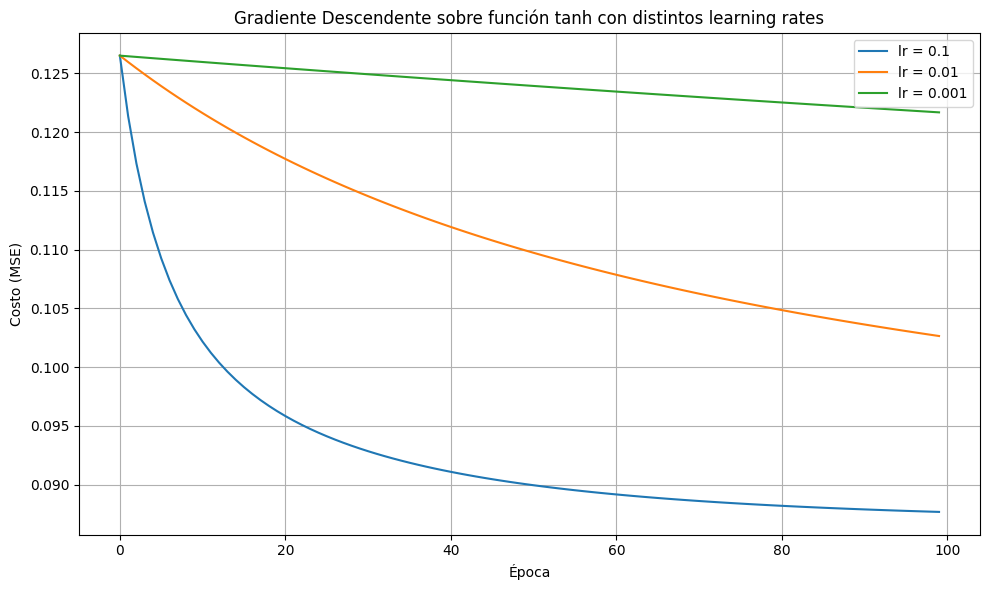

In [362]:
# Graficar
plt.figure(figsize=(10, 6))
for lr, cost in GD_results.items():
    plt.plot(cost, label=f'lr = {lr}')
plt.xlabel('Época')
plt.ylabel('Costo (MSE)')
plt.title('Gradiente Descendente sobre función tanh con distintos learning rates')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

A medida que se reduce el learning rate le cuesta mucho más converger. El lr en 0.1 reduce rapidamente el error en las primeras épocas y logra una buena convergencia. En cambio, al achivar el lr las curvas comienzan a descender muy lentamente o casi no descienden como es el caso de lr en 0.001.

### 1b) Implementación de Adam (1 punto)  
- Implementar el algoritmo de Adam para minimizar \\( J(w, b) \\).  
- Utilizar 100 épocas y 3 diferentes learning rates `(0.1, 0.01, 0.001)`.
- Utilizar los mismos valores de \\( w \\) y \\( b \\) que se usaron para GD para cada diferente learning rate.
- Graficar la función de Costo \\( J(w, b) \\) VS número de época
- Hacer 2 modelos, uno sin mini-batch y otro con mini-batch.

\\

Al igual que para GD, el optimizador Adam también se debe implementar desde cero y paso a paso. Se pueden usar librerías como `numpy`, `scipy`, `matplotlib` o similares. Pero no está permitido usar Pytorch ni TensorFlow o frameworks que ya contengan el optimizador desarrollado.

In [363]:
def adam_optimizer(x, y, lr=0.01, epochs=100, beta1=0.9, beta2=0.999, epsilon=1e-8, w_init=None, b_init=None):
    m = len(x)
    
    np.random.seed(42)  # Defino semilla para reproducibilidad en toda la notebook
    w = np.random.randn() if w_init is None else w_init
    b = np.random.randn() if b_init is None else b_init

    print(f"Initial parameters: w={w}, b={b}")

    mw, mb = 0, 0  # Momentos del gradiente
    vw, vb = 0, 0  # Momentos del gradiente al cuadrado
    cost_history = []
    trajectory = [(w, b)]

    for t in range(1, epochs + 1):
        z = w * x + b
        y_hat = np.tanh(z)
        error = y_hat - y
        dz = (1 - np.tanh(z) ** 2)

        dw = (2/m) * np.sum(error * dz * x)
        db = (2/m) * np.sum(error * dz)

        # Actualización de momentos
        mw = beta1 * mw + (1 - beta1) * dw
        mb = beta1 * mb + (1 - beta1) * db

        vw = beta2 * vw + (1 - beta2) * (dw ** 2)
        vb = beta2 * vb + (1 - beta2) * (db ** 2)

        # Corrección de sesgo
        mw_hat = mw / (1 - beta1 ** t)
        mb_hat = mb / (1 - beta1 ** t)

        vw_hat = vw / (1 - beta2 ** t)
        vb_hat = vb / (1 - beta2 ** t)

        # Actualización de parámetros
        w -= lr * mw_hat / (np.sqrt(vw_hat) + epsilon)
        b -= lr * mb_hat / (np.sqrt(vb_hat) + epsilon)

        cost = mse_cost(y_hat, y, m)
        cost_history.append(cost)
        trajectory.append((w, b))

    return w, b, cost_history, trajectory

In [364]:
adam_results = {}
adam_trajectory = {}

for lr in learning_rates:
    w, b, cost, trajectory = adam_optimizer(x, y, lr=lr, epochs=100)
    adam_results[lr] = cost
    adam_trajectory[lr] = trajectory

Initial parameters: w=0.4967141530112327, b=-0.13826430117118466
Initial parameters: w=0.4967141530112327, b=-0.13826430117118466
Initial parameters: w=0.4967141530112327, b=-0.13826430117118466


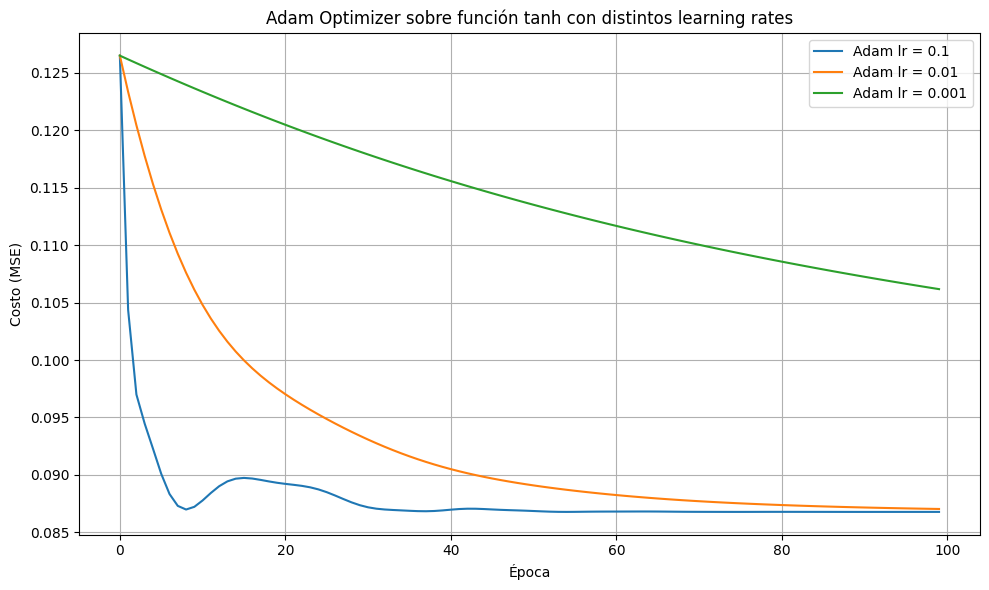

In [365]:
# Graficar comparativa
plt.figure(figsize=(10, 6))
for lr, cost in adam_results.items():
    plt.plot(cost, label=f'Adam lr = {lr}')
plt.xlabel('Época')
plt.ylabel('Costo (MSE)')
plt.title('Adam Optimizer sobre función tanh con distintos learning rates')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Con Adam, todos los learning rates logran una reducción efectiva del error, pero lr = 0.01 ofrece el mejor equilibrio entre velocidad de convergencia y estabilidad. En cambio, lr = 0.1 converge más rápido pero con oscilaciones, y lr = 0.001 es estable pero más lento en alcanzar el mínimo.

In [366]:
def adam_optimizer_minibatch(x, y, lr=0.01, epochs=100, batch_size=32, beta1=0.9, beta2=0.999, epsilon=1e-8, w_init=None, b_init=None):
    m = len(x)
    
    np.random.seed(42)  # Defino semilla para reproducibilidad en toda la notebook
    w = np.random.randn() if w_init is None else w_init
    b = np.random.randn() if b_init is None else b_init

    print(f"Initial parameters: w={w}, b={b}")

    mw, mb = 0, 0
    vw, vb = 0, 0
    cost_history = []
    trajectory = [(w, b)]

    # Calcular y guardar el costo inicial antes de la primera época
    z_init = w * x + b
    y_hat_init = np.tanh(z_init)
    cost_init = (1/m) * np.sum((y_hat_init - y) ** 2)
    cost_history = [cost_init]


    for t in range(1, epochs + 1):
        indices = np.random.permutation(m)
        x_shuffled = x[indices]
        y_shuffled = y[indices]

        for i in range(0, m, batch_size):
            x_batch = x_shuffled[i:i+batch_size]
            y_batch = y_shuffled[i:i+batch_size]
            mb_size = len(x_batch)

            z = w * x_batch + b
            y_hat = np.tanh(z)
            error = y_hat - y_batch
            dz = (1 - np.tanh(z)**2)

            dw = (2/mb_size) * np.sum(error * dz * x_batch)
            db = (2/mb_size) * np.sum(error * dz)

            mw = beta1 * mw + (1 - beta1) * dw
            mb = beta1 * mb + (1 - beta1) * db
            vw = beta2 * vw + (1 - beta2) * dw**2
            vb = beta2 * vb + (1 - beta2) * db**2

            mw_hat = mw / (1 - beta1**t)
            mb_hat = mb / (1 - beta1**t)
            vw_hat = vw / (1 - beta2**t)
            vb_hat = vb / (1 - beta2**t)

            w -= lr * mw_hat / (np.sqrt(vw_hat) + epsilon)
            b -= lr * mb_hat / (np.sqrt(vb_hat) + epsilon)

        # Evaluar costo en todos los datos tras cada época
        z_full = w * x + b
        y_hat_full = np.tanh(z_full)
        cost = mse_cost(y_hat_full, y, m)
        cost_history.append(cost)
        trajectory.append((w, b))

    return w, b, cost_history, trajectory

In [367]:
adam_minibatch_results = {}
adam_minibatch_trajectory = {}
for lr in learning_rates:
    w, b, cost, trajectory = adam_optimizer_minibatch(x, y, lr=lr, epochs=100, batch_size=32)
    adam_minibatch_results[lr] = cost
    adam_minibatch_trajectory[lr] = trajectory

Initial parameters: w=0.4967141530112327, b=-0.13826430117118466
Initial parameters: w=0.4967141530112327, b=-0.13826430117118466
Initial parameters: w=0.4967141530112327, b=-0.13826430117118466


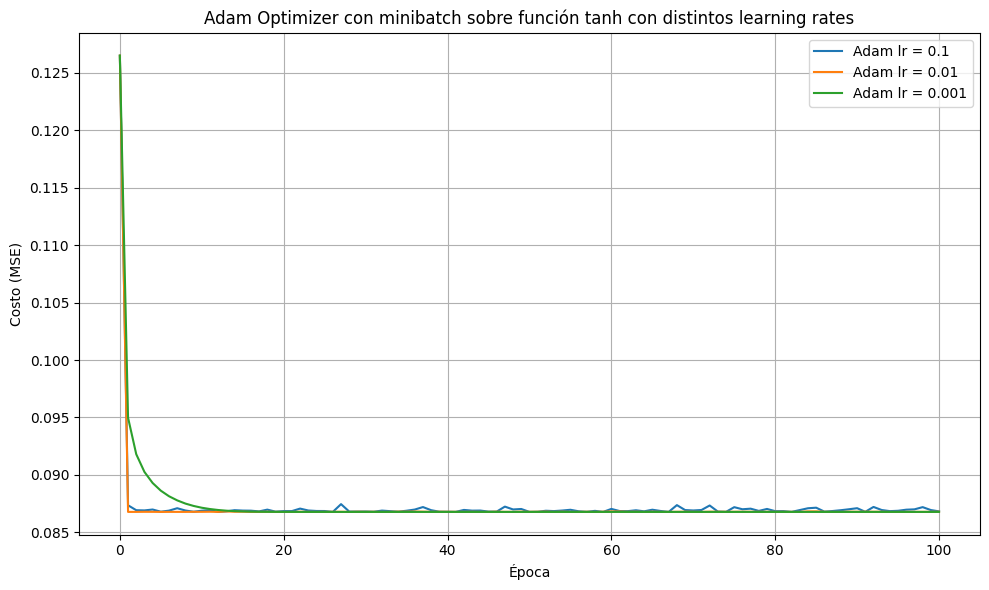

In [368]:
# Graficar comparativa
plt.figure(figsize=(10, 6))
for lr, cost in adam_minibatch_results.items():
    plt.plot(cost, label=f'Adam lr = {lr}')
plt.xlabel('Época')
plt.ylabel('Costo (MSE)')
plt.title('Adam Optimizer con minibatch sobre función tanh con distintos learning rates')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Con Adam y mini-batch, los tres learning rates convergen rápidamente al mismo mínimo, pero lr = 0.01 y lr = 0.001 lo hacen de forma más suave y estable. En cambio, lr = 0.1 muestra oscilaciones leves, típicas del entrenamiento por lotes con tasa alta.

### 1c) Comparativa de optimizadores (0.5 puntos)  
- Comparar el resultado y rendimiento de GD VS Adam (sin mini-batch) VS Adam (con mini-batch) para cada uno de los learning rates.
- Redactar conclusiones analíticas que resalten las diferencias entre cada optimizador.

Learning Rate en 0.1:

- **GD**: converge rápido al principio y luego estabiliza temprano con un error un poco mayor a Adam.
- **Adam**:  desciende bruscamente y alcanza el mínimo más bajo, aunque con oscilaciones marcadas por el alto lr.
- **Adam con mini-batch**: converge igual de rápido, pero muestra oscilaciones debido al ruido de los lotes pequeños.

Learning Rate en 0.01:

- **GD**: mejora progresiva y estable, pero a un ritmo más lento.
- **Adam**: rápida convergencia, sin oscilaciones, y alcanza el mejor error final.
- **Adam con mini-batch**: converge desde el primer momento y se estabiliza temprano con el mejor error alcanzado en el experimento.

Learning Rate en 0.001:

- **GD**: converge muy lentamente, casi plano.
- **Adam**: mejora constante aunque lenta, pero finalmente reduce el MSE mucho más que GD.
- **Adam con mini-batch**: converge rápido manteniendo estabilidad.

### 1d) Visualización en 3D de la trayectoria de aprendizaje (0.5 puntos)
- Graficar en 3D la trayectoria del aprendizaje de los 3 optimizadores sobre la superficie de la función de costo \\( J(w, b) \\). Se debe elegir un solo learning rate.
- Comparar y redactar cómo se mueven en el espacio de parámetros y qué diferencias existen en la convergencia.
- Recomiendo utilizar `mpl_toolkits.mplot3d` y `np.meshgrid`, pero queda a su criterio la elección de funciones a usar para lograr el gráfico.

In [369]:
# Mallado mejor aproximación lineal
X1 = np.linspace(0, 1.5, 100)
X2 = np.linspace(-0.5, 0.5, 100)
X1, X2 = np.meshgrid(X1, X2)

In [370]:
# Cálculo de la superficie J(w, b)
def calcular_cost_surface(W, B, x, y):
    Z = np.tanh(W[np.newaxis, :, :] * x[:, np.newaxis, np.newaxis] + B[np.newaxis, :, :])
    mse = np.mean((Z - y[:, np.newaxis, np.newaxis])**2, axis=0)
    return mse


J = calcular_cost_surface(X1, X2, x, y)

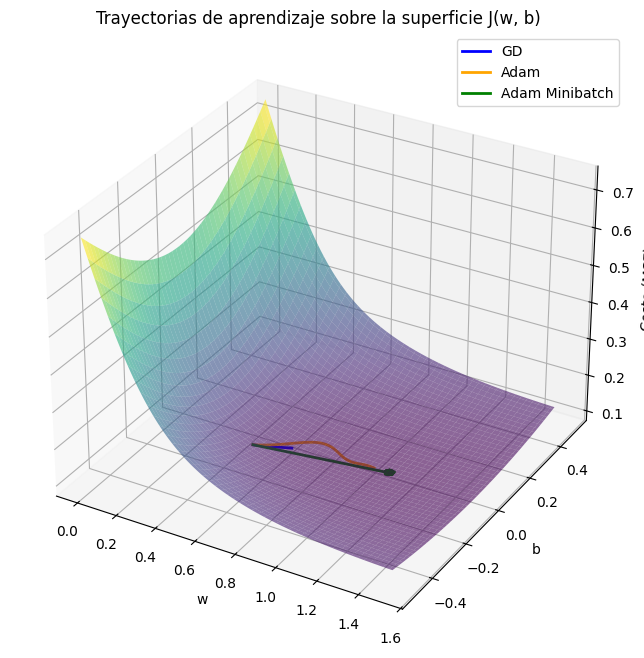

In [371]:
# Gráfico 3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Superficie de la función de costo
ax.plot_surface(X1, X2, J, cmap='viridis', alpha=0.6, edgecolor='none')

# Función para graficar cada trayectoria
def plot_traj(ax, traj, label, color):
    traj = np.array(traj)
    w_path, b_path = traj[:, 0], traj[:, 1]
    Z_path = np.tanh(np.outer(w_path, x) + b_path[:, None])
    cost_path = np.mean((Z_path - y)**2, axis=1)
    ax.plot(w_path, b_path, cost_path, label=label, color=color, linewidth=2)

# Dibujar trayectorias
plot_traj(ax, GD_trajectory[0.01], 'GD', 'blue')
plot_traj(ax, adam_trajectory[0.01], 'Adam', 'orange')
plot_traj(ax, adam_minibatch_trajectory[0.01], 'Adam Minibatch', 'green')

# Etiquetas
ax.set_xlabel('w')
ax.set_ylabel('b')
ax.set_zlabel('Costo (MSE)')
ax.set_title('Trayectorias de aprendizaje sobre la superficie J(w, b)')
ax.legend()
plt.show()

Se observa que Adam y Adam con minibatch convergen más rápidamente hacia el mínimo en comparación con Gradiente Descendente, que sigue una trayectoria más lenta y menos directa. Además, Adam con minibatch alcanza una trayectoria más suave y estable, beneficiándose de la aleatorización de los batches. Esta visualización refuerza la eficiencia y precisión del optimizador Adam, especialmente cuando se combina con entrenamiento en minibatches.

# **PREGUNTA 2**

Descargar el dataset del siguiente link: https://drive.google.com/file/d/147YyKAiQhJhZV9tHAkrgcTzvRgmwB-OX/view?usp=sharing.

El dataset consiste en compras de productos que diferentes clientes realizaron durante un black sales. El dataset contiene información sobre las transacciones, compuestas por un cliente y el producto que adquirió.


In [372]:
output_path = ""

# Función para descargar un archivo solo si no existe
def descargar_si_no_existe(url_id, output_path):
    if not os.path.exists(output_path):
        gdown.download(url + url_id, output_path, quiet=False)

url = 'https://drive.google.com/uc?id='

### Archivos Utiles:
descargar_si_no_existe('147YyKAiQhJhZV9tHAkrgcTzvRgmwB-OX', 'dataset_compras.csv')


In [373]:
df = pd.read_csv('dataset_compras.csv')

### 2a) EDA y preparación del dataset (2.5 puntos)
Realizar el análisis exploratorio del dataset (EDA) con las herramientas vistas en materias anteriores. Pre-procesar y transformar las variables que sean necesarias, analizar qué columnas se deben dropear, cuáles vale la pena hacer un tratamiento de valores nulos, si se debe usar label encoding, one-hot encoding o mapping encoding, explicar los criterios utilizados y analizar las distribuciones.

Vamos a tratar este problema como una clasificación donde queremos averiguar si el cliente pertenece a un segmento: "Casual" (gasta menos de 3000), "Gama media" (gasta entre 3000 y 8000), "Gama alta" (gasta entre 8000 y 18000) o a "Premium" (gasta más de 18000), según el producto que adquirió.

Redactar las conclusiones preliminares que pueden notar de las columnas y justificar el porqué de cada encoding aplicado.

**IMPORTANTE: Luego de asignar los segmentos, no se olviden de eliminar la columna "Purchase".**

In [374]:
# Mostrar las primeras filas del DataFrame
df.head()

User_ID Product_ID    Age Gender  Marital_Status City_Category  \
0  1044096  P00017122  46-50      F               1             B   
1  1071818  P00074517  36-45      M               0             A   
2  1022986  P00013694  36-45      M               1             A   
3  1094684  P00049122  36-45      M               1             A   
4  1004157  P00006469  46-50      M               1             A   

  Stay_In_Current_City_Years  Product_Category  Product_Subcategory_1  \
0                          1                10                   45.0   
1                          3                11                   27.0   
2                         5+                 4                   28.0   
3                          1                16                    9.0   
4                         5+                 3                    NaN   

   Product_Subcategory_2  Purchase  
0                    NaN      1810  
1                    NaN     12351  
2                    NaN       127  
3                    8.0      2214  
4                    NaN      7142

In [375]:
# Mostrar información del DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182721 entries, 0 to 182720
Data columns (total 11 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   User_ID                     182721 non-null  int64  
 1   Product_ID                  182721 non-null  object 
 2   Age                         182721 non-null  object 
 3   Gender                      182721 non-null  object 
 4   Marital_Status              182721 non-null  int64  
 5   City_Category               182721 non-null  object 
 6   Stay_In_Current_City_Years  182721 non-null  object 
 7   Product_Category            182721 non-null  int64  
 8   Product_Subcategory_1       140903 non-null  float64
 9   Product_Subcategory_2       77461 non-null   float64
 10  Purchase                    182721 non-null  int64  
dtypes: float64(2), int64(4), object(5)
memory usage: 15.3+ MB


- Las variables son en su mayoría categoricas. El `Marital_Status` viene binario y las categorias de los productos son numéricas.
- Las subcategorias de los productos presentan nulos.

In [376]:
# Creo variable target
condiciones = [
    df["Purchase"] < 3000,
    df["Purchase"].between(3000, 8000, inclusive='both'),
    df["Purchase"].between(8001, 18000, inclusive='both'),
    df["Purchase"] > 18000
]

valores = ["Casual", "Gama media", "Gama alta", "Premium"]

df["segmento"] = np.select(condiciones, valores)

In [377]:
# Profile Report
profile = ProfileReport(df, title="Informe Exploratorio", explorative=True)
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 12/12 [00:00<00:00, 36.53it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

- El dataset tiene un 1.2% de filas duplicadas, que podrían eliminarse si no aportan información adicional.
- Hay alta correlación entre variables demográficas (`Age`, `Gender`, `Marital_Status`, `City_Category`), lo que podría causar multicolinealidad.
- `segmento` está altamente correlado con `Product_Category`, lo cual puede deberse a que la variable es numérica pero representa categorías. Esta codificación puede inducir una falsa interpretación ordinal.
- Las columnas `Product_Subcategory_1` y `Product_Subcategory_2` presentan valores faltantes significativos (22.9% y 57.6%), lo que requiere imputación o eliminación.

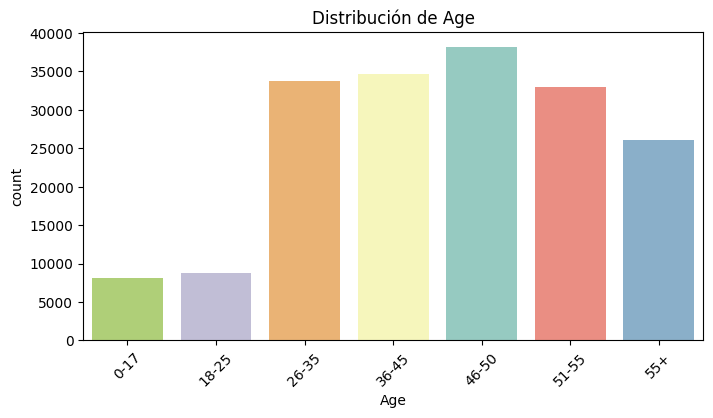

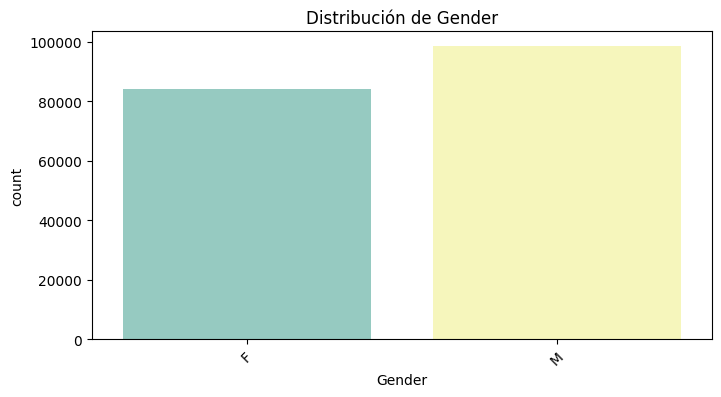

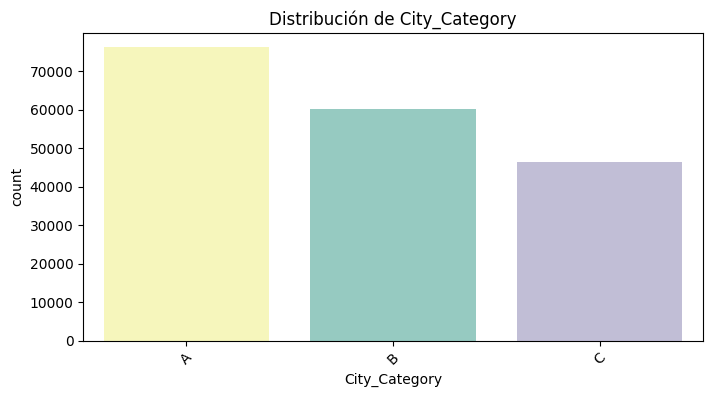

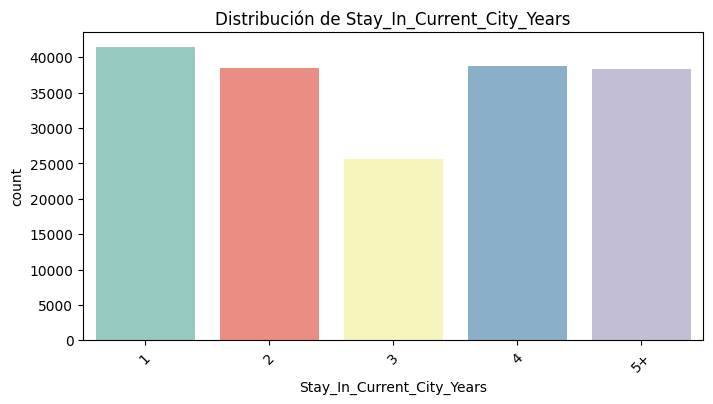

In [378]:
# Variables categóricas
cat_cols = df.drop(columns=['User_ID', 'Product_ID', 'Purchase', 'segmento']).select_dtypes(include=['object', 'category']).columns.tolist()

for col in cat_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=df, x=col, hue=col, palette='Set3', dodge=False, legend=False,
                  order=sorted(df[col].dropna().unique()))
    plt.title(f"Distribución de {col}")
    plt.xticks(rotation=45)
    plt.show()

In [379]:
# Preprocesamiento de variables categóricas

# 1. Mapeo manual para stay_in_city: convirtiendola a entero.
df['Stay_In_Current_City_Years'] = df['Stay_In_Current_City_Years'].replace({'5+': 5}).astype(int)

# 2. Defino orden de Age
age_order = ['0-17', '18-25', '26-35', '36-45', '46-50', '51-55', '55+']
df['Age'] = pd.Categorical(df['Age'], categories=age_order, ordered=True)

# 3. Definición de columnas para codificación
onehot_cols = ['City_Category']
ordinal_cols = ['Age', 'Gender'] # Convierte Gender a binaria

# 4. Preprocesador para variables categóricas con escalado en las ordinales
preprocessor_cat = ColumnTransformer(transformers=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False), onehot_cols),
    ('ordinal_scaled', Pipeline(steps=[
        ('encoder', OrdinalEncoder(categories=[age_order, ['F', 'M']], handle_unknown='use_encoded_value', unknown_value=-1)),
        ('scaler', StandardScaler())
    ]), ordinal_cols)
])

Se aplicaron distintas transformaciones a las **variables categóricas** para prepararlas para los modelos de machine learning:

- **`Stay_In_Current_City_Years`**: Aunque originalmente es una variable categórica con valores como `'1'`, `'2'`, `'5+'`, se transformó en variable ordinal entera, reemplazando `'5+'` por `5`, ya que representa años de residencia y tiene un orden implícito.

- **`Age`**: Es una variable categórica con rangos de edad (`'18-25'`, `'26-35'`, etc.). Se estableció un orden explícito para conservar su naturaleza ordinal y se codificó con `OrdinalEncoder` utilizando ese orden, evitando la expansión de columnas que implicaría un One-Hot.

- **`Gender`**: Es una variable binaria (`'M'` / `'F'`). Se codificó con `OrdinalEncoder`, que la transforma en valores numéricos (`0` o `1`). Esta codificación es simple y eficiente para variables binarias.

- **`City_Category`**: Es una variable nominal (`'A'`, `'B'`, `'C'`), sin un orden natural entre sus categorías. Por eso, se utilizó **One-Hot Encoding**, lo que permite representar cada ciudad como una columna binaria sin inducir orden.

Esta combinación de `OrdinalEncoder` y `OneHotEncoder` permite representar correctamente las relaciones entre categorías y reducir la dimensionalidad cuando es posible, manteniendo la interpretabilidad y evitando errores en los modelos.

Todas las variables codificadas mediante `OrdinalEncoder` se escalaron posteriormente con `StandardScaler`. Esto es importante en modelos de deep learning, ya que mejora la convergencia del entrenamiento al asegurar que todas las variables tengan media 0 y varianza 1, evitando que ciertas features dominen el aprendizaje por tener mayor rango numérico.

In [380]:
# Preprocesamiento de variables con nulos

null_cols = ['Product_Subcategory_1', 'Product_Subcategory_2']

preprocessor_nulls = ColumnTransformer(transformers=[
    ('impute_and_encode', Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value=-1)), # Reemplaza nulos con -1
    ]), null_cols)
])

Las columnas `Product_Subcategory_1` y `Product_Subcategory_2` presentan valores faltantes significativos (22.9% y 57.6%, respectivamente). Dado que estas variables representan categorías numéricas, se decidió aplicar la siguiente estrategia de imputación:

- **Imputación con el valor `-1`**: Esto permite distinguir explícitamente los registros con valores faltantes, tratando los nulos como una categoría aparte en lugar de asumir una categoría válida.

Esta combinación permite conservar todos los registros sin pérdida de información y mantener la interpretabilidad de los datos imputados.

In [381]:
# Variables de categorías de productos
categories = ['Product_Category', 'Product_Subcategory_1', 'Product_Subcategory_2']

# Codificarlas como categorías
for col in categories:
    df[col] = df[col].astype('category')

# Preprocesamiento de variables categóricas numéricas sin orden pero de alta cardinalidad
preprocessor_prod_cat = ColumnTransformer(transformers=[
    ('impute_encode_scale', Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value=-1)), # Reemplaza nulos con -1
        ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
        ('scaler', StandardScaler())
    ]), categories)
])

Las variables `Product_Category`, `Product_Subcategory_1` y `Product_Subcategory_2` son variables categóricas representadas como números enteros, pero **no poseen un orden natural** entre categorías (por ejemplo, la categoría 3 no es "mayor" ni "mejor" que la 2). Además, presentan **alta cardinalidad**, lo que hace inviable el uso de One-Hot Encoding por la cantidad excesiva de columnas que generaría.

Por eso, se decidió tratarlas como categorías puras, codificándolas con `OrdinalEncoder` (sin asumir orden), y luego aplicarles **`StandardScaler`**. Con `StandardScaler`, se asegura que todas las variables tengan media 0 y desviación estándar 1, mejorando la eficiencia y estabilidad del entrenamiento.

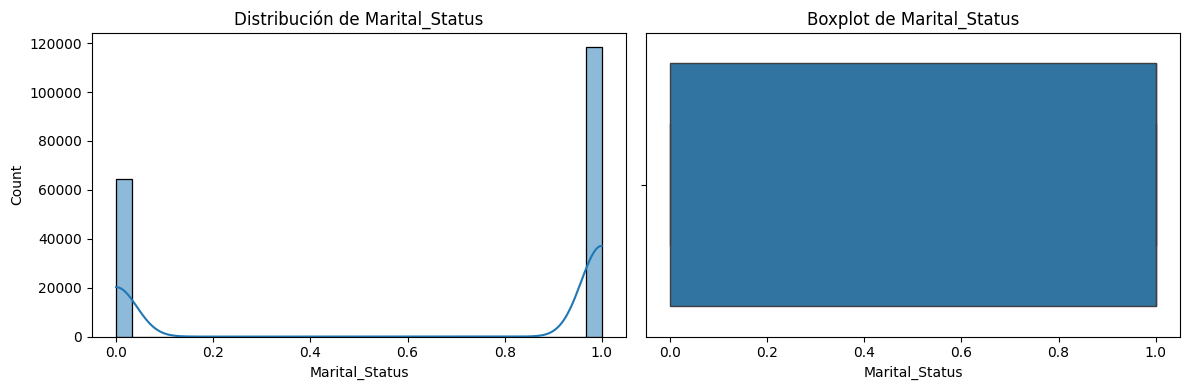

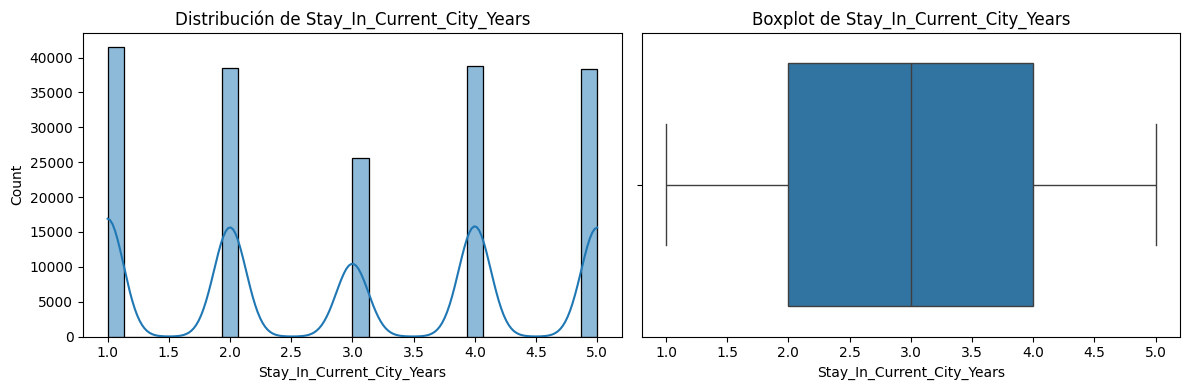

In [382]:
numeric_cols = df.drop(columns=['User_ID', 'Product_ID', 'Purchase', 'segmento']).select_dtypes(include=['int64', 'float64']).columns.tolist()

for col in numeric_cols:
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    
    sns.histplot(df[col], kde=True, ax=ax[0], bins=30)
    ax[0].set_title(f'Distribución de {col}')
    
    sns.boxplot(x=df[col], ax=ax[1])
    ax[1].set_title(f'Boxplot de {col}')
    
    plt.tight_layout()
    plt.show()

In [383]:
numeric_cols = ['Stay_In_Current_City_Years', 'Marital_Status'] # Variables numéricas a escalar

# Preprocesamiento de variables numéricas
preprocessor_num = ColumnTransformer(transformers=[
    ('numeric_scaled', Pipeline([
        ('scaler', StandardScaler())
    ]), numeric_cols)
])

Las variables `Stay_In_Current_City_Years` y `Marital_Status` fueron tratadas como variables numéricas y escaladas utilizando `StandardScaler`. Esto asegura que ambas tengan media 0 y desviación estándar 1, lo cual es fundamental para el entrenamiento eficiente de modelos de deep learning, ya que evita que variables con escalas mayores dominen el aprendizaje.

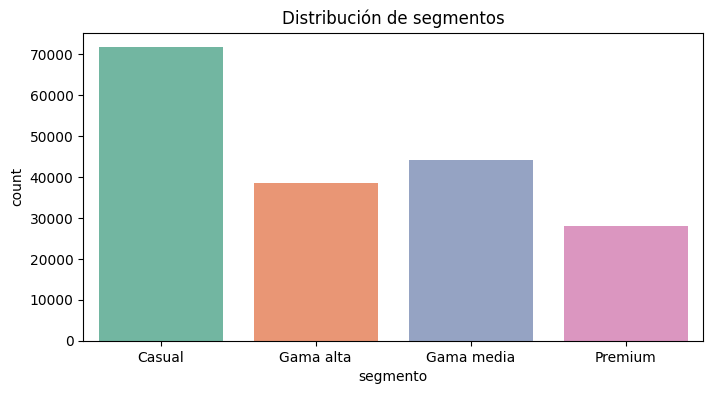

In [384]:
# Distribución de segmentos
plt.figure(figsize=(8, 4))
sns.countplot(data=df, x='segmento', hue='segmento', palette='Set2', legend=False)
plt.title("Distribución de segmentos")
plt.show()

La variable `segmento` representa una clasificación de los clientes según el monto gastado (`Purchase`), agrupado en cuatro niveles: **Casual**, **Gama media**, **Gama alta** y **Premium**.

La distribución es **desbalanceada**, con una fuerte concentración en el segmento **Casual**, que representa la mayoría de los registros. Esto sugiere que los modelos de clasificación podrían estar sesgados hacia esta clase si no se toman medidas.

In [385]:
# Balanceo de clases con SMOTE
smote = SMOTE(random_state=42)

In [386]:
# Elimino variable Purchase
df.drop(columns=["Purchase"], inplace=True)

#### Definición del pipeline de preprocesamiento

In [387]:
full_preprocessor = ColumnTransformer(transformers=[
    ('cat', preprocessor_cat, onehot_cols + ordinal_cols),
    ('prod_cat', preprocessor_prod_cat, categories),
    ('num', preprocessor_num, numeric_cols)
])

pipeline = Pipeline(steps=[
    ('preprocessor', full_preprocessor),
    ('smote', smote)
])

In [388]:
X_resampled, y_resampled = pipeline.fit_resample(df.drop(columns=['segmento', 'User_ID', 'Product_ID']), df['segmento'])

In [389]:
# Obtener nombres de columnas transformadas
feature_names = full_preprocessor.get_feature_names_out()

# Crear DataFrame con features + target
df_resampled = pd.DataFrame(X_resampled, columns=feature_names)
df_resampled['segmento'] = y_resampled.values

# Mostrar primeras filas
df_resampled.head()

cat__onehot__City_Category_A  cat__onehot__City_Category_B  \
0                           0.0                           1.0   
1                           1.0                           0.0   
2                           1.0                           0.0   
3                           1.0                           0.0   
4                           1.0                           0.0   

   cat__onehot__City_Category_C  cat__ordinal_scaled__Age  \
0                           0.0                  0.255183   
1                           0.0                 -0.358092   
2                           0.0                 -0.358092   
3                           0.0                 -0.358092   
4                           0.0                  0.255183   

   cat__ordinal_scaled__Gender  \
0                    -1.083206   
1                     0.923185   
2                     0.923185   
3                     0.923185   
4                     0.923185   

   prod_cat__impute_encode_scale__Product_Category  \
0                                        -0.111159   
1                                         0.065530   
2                                        -1.171288   
3                                         0.948971   
4                                        -1.347976   

   prod_cat__impute_encode_scale__Product_Subcategory_1  \
0                                           1.595141      
1                                           0.635739      
2                                           0.722957      
3                                          -0.672536      
4                                          -1.283064      

   prod_cat__impute_encode_scale__Product_Subcategory_2  \
0                                          -0.707918      
1                                          -0.707918      
2                                          -0.707918      
3                                           0.047392      
4                                          -0.707918      

   num__numeric_scaled__Stay_In_Current_City_Years  \
0                                        -1.335997   
1                                         0.021837   
2                                         1.379670   
3                                        -1.335997   
4                                         1.379670   

   num__numeric_scaled__Marital_Status    segmento  
0                             0.737728      Casual  
1                            -1.355513   Gama alta  
2                             0.737728      Casual  
3                             0.737728      Casual  
4                             0.737728  Gama media

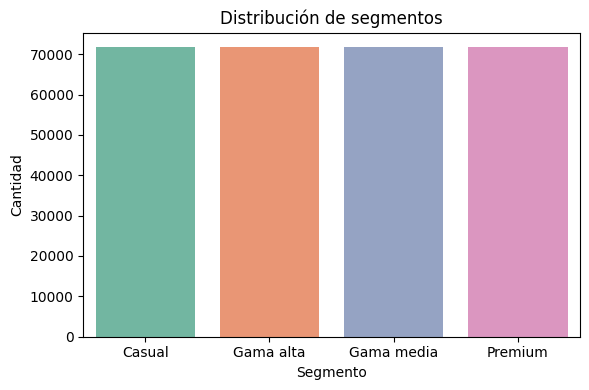

In [390]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df_resampled, x='segmento', hue='segmento', palette='Set2', legend=False)
plt.title("Distribución de segmentos")
plt.ylabel("Cantidad")
plt.xlabel("Segmento")
plt.tight_layout()
plt.show()

Luego de aplicar el preprocesamiento completo, todas las variables predictoras fueron correctamente transformadas:

- Las variables categóricas se codificaron mediante una combinación de **One-Hot Encoding** y **Ordinal Encoding**, según su naturaleza (nominal u ordinal).
- Todas las variables numéricas y categóricas codificadas fueron **escaladas** con `StandardScaler`, asegurando que tengan media 0 y varianza 1, lo cual es fundamental para el entrenamiento de modelos basados en redes neuronales.
- Las variables con valores faltantes fueron **imputadas** de manera consistente para no perder información.

Además, la variable objetivo `segmento` fue **balanceada con la técnica SMOTE**, generando observaciones sintéticas en las clases minoritarias. Esto permite entrenar modelos más robustos, evitando el sesgo hacia la clase mayoritaria presente en los datos originales.

El dataset final está listo para ser utilizado en tareas de clasificación con modelos de deep learning.

### 2b) Modelo de deep leaning sin embeddings (1.5 puntos)
Entrenar un modelo de deep learning usando Pytorch que no utilice embeddings, **descartando el `product_id` y `user_id`**. Graficar las evoluciones por época de la función de costo y de métricas como el accuracy y el f1 score para train y validation. Mostrar una matriz de confusión absoluta y otra normalizada por fila. Explicar el proceso de iteracion utilizado para conseguir los resultados y justificar los resultados obtenidos.

Pueden usarse herramientas de regularización y prueba de hiperpametros para conseguir mejores resultados.

Un resultado aceptable sería al menos un 77% de accuracy y f1 score para el set de validation.

In [391]:
# 1. Separar features y target
X = df.drop(columns='segmento')
y = df['segmento']

# 2. Hacer split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 3. Aplicar preprocesador a entrenamiento (fit + transform)
X_train_pre = full_preprocessor.fit_transform(X_train, y_train)

# 4. Aplicar preprocesador a test (solo transform)
X_test_pre = full_preprocessor.transform(X_test)

# 5. Convertir a denso si es sparse
if hasattr(X_train_pre, "toarray"):
    X_train_pre = X_train_pre.toarray()
if hasattr(X_test_pre, "toarray"):
    X_test_pre = X_test_pre.toarray()

# 6. Aplicar SMOTE solo al set de entrenamiento
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_pre, y_train)

# 7. Encodear las etiquetas
le = LabelEncoder()
y_train_resampled_encoded = le.fit_transform(y_train_resampled)
y_test_encoded = le.transform(y_test)

# 8. Convertir a tensores de PyTorch
X_train_tensor = torch.tensor(X_train_resampled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_resampled_encoded, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_pre, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_encoded, dtype=torch.long)

In [392]:
# Pytorch necesita de una clase de dataset que extienda de torch.utils.data.Dataset
# Esta clase dataset debe sobreescribir los métodos init, len y getitem
class MyDataset(Dataset):

  #__init__ guarda el dataset en una variable de clase
  def __init__(self, x, y):
    self.x = x
    self.y = y

  # __len__ define el comportamiento de la función len() sobre el objeto
  def __len__(self):
    return self.x.shape[0]

  # __getitem__ define el comportamiento de los []
  def __getitem__(self, idx):
    return self.x[idx], self.y[idx]

In [393]:
# Creo el dataset de entrenamiento y validación
train_ds = MyDataset(X_train_tensor, y_train_tensor)
valid_ds = MyDataset(X_test_tensor, y_test_tensor)

# DataLoaders
train_dataloader = DataLoader(train_ds, batch_size=64, shuffle=True)
valid_dataloader = DataLoader(valid_ds, batch_size=64)

#### Entrenamiento Baseline

In [394]:
class NNet(torch.nn.Module):

  def __init__(self, input_dim, output_dim):
    # Defino la arquitectura de la red
    super().__init__()
    self.linear_1 = torch.nn.Linear(in_features=input_dim, out_features=200, bias=True)
    self.relu_1 = torch.nn.ReLU()
    self.linear_2 = torch.nn.Linear(in_features = 200, out_features=100, bias=True)
    self.relu_2 = torch.nn.ReLU()
    self.output = torch.nn.Linear(in_features = 100, out_features= output_dim, bias=True)

  def forward(self, x):
    # Defino el cálculo del paso forward
    x = self.linear_1(x)
    x = self.relu_1(x)
    x = self.linear_2(x)
    x = self.relu_2(x)
    x = self.output(x)
    return x

In [395]:
# Instanciamos la red
nnet = NNet(input_dim=X_train_tensor.shape[1], output_dim=4)

**Loss y optimizador:**

- Como loss function utilizo CrossEntropyLoss por ser un problema de clasificación multiclase.

- Como optimizador utilizo Adam

In [396]:
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(nnet.parameters(), lr=0.01)

In [397]:
device = "cpu"
if torch.cuda.is_available():
  device = "cuda:0"

device

'cpu'

In [398]:
# Copio la red neuronal al dispositivo donde entrene la red neuronal
nnet = nnet.to(device)

In [ ]:
# Cantidad de épocas
epochs = 100

train_loss_by_epoch = []
valid_loss_by_epoch = []
train_acc_by_epoch = []
valid_acc_by_epoch = []
train_f1_by_epoch = []
valid_f1_by_epoch = []

for epoch in range(epochs):
    ########################################
    # Entrenamiento
    ########################################
    nnet.train()
    epoch_loss = 0
    epoch_y = []
    epoch_y_hat = []

    for x_batch, y_batch in train_dataloader:
        x_batch = x_batch.to(device).float()
        y_batch = y_batch.to(device).long()

        optimizer.zero_grad()
        outputs = nnet(x_batch)  # logits

        loss = loss_function(outputs, y_batch)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)

        epoch_y += y_batch.cpu().numpy().tolist()
        epoch_y_hat += preds.cpu().numpy().tolist()

    avg_loss = epoch_loss / len(train_dataloader)
    train_loss_by_epoch.append(avg_loss)
    train_acc_by_epoch.append(accuracy_score(epoch_y, epoch_y_hat))
    train_f1_by_epoch.append(f1_score(epoch_y, epoch_y_hat, average='macro'))

    ########################################
    # Validación
    ########################################
    nnet.eval()
    valid_loss = 0
    valid_y = []
    valid_y_hat = []

    with torch.no_grad():
        for x_batch, y_batch in valid_dataloader:
            x_batch = x_batch.to(device).float()
            y_batch = y_batch.to(device).long()

            outputs = nnet(x_batch)
            loss = loss_function(outputs, y_batch)
            valid_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            valid_y += y_batch.cpu().numpy().tolist()
            valid_y_hat += preds.cpu().numpy().tolist()

    avg_valid_loss = valid_loss / len(valid_dataloader)
    valid_loss_by_epoch.append(avg_valid_loss)
    valid_acc_by_epoch.append(accuracy_score(valid_y, valid_y_hat))
    valid_f1_by_epoch.append(f1_score(valid_y, valid_y_hat, average='macro'))

    ########################################
    # Logging
    ########################################
    print(f"Epoch {epoch:03} | "
          f"Train/Valid Loss: {avg_loss:.4f}/{avg_valid_loss:.4f} | "
          f"Train/Valid Acc: {train_acc_by_epoch[-1]:.3f}/{valid_acc_by_epoch[-1]:.3f} | "
          f"Train/Valid F1: {train_f1_by_epoch[-1]:.3f}/{valid_f1_by_epoch[-1]:.3f}")

Epoch 000 | Train/Valid Loss: 0.7305/0.7782 | Train/Valid Acc: 0.660/0.665 | Train/Valid F1: 0.649/0.640
Epoch 001 | Train/Valid Loss: 0.6195/0.5730 | Train/Valid Acc: 0.710/0.725 | Train/Valid F1: 0.702/0.698
Epoch 002 | Train/Valid Loss: 0.5683/0.5231 | Train/Valid Acc: 0.738/0.753 | Train/Valid F1: 0.731/0.733
Epoch 003 | Train/Valid Loss: 0.5492/0.5050 | Train/Valid Acc: 0.746/0.757 | Train/Valid F1: 0.739/0.729
Epoch 004 | Train/Valid Loss: 0.5371/0.5106 | Train/Valid Acc: 0.749/0.754 | Train/Valid F1: 0.743/0.721
Epoch 005 | Train/Valid Loss: 0.5293/0.4920 | Train/Valid Acc: 0.753/0.762 | Train/Valid F1: 0.748/0.737
Epoch 006 | Train/Valid Loss: 0.5243/0.5059 | Train/Valid Acc: 0.755/0.761 | Train/Valid F1: 0.749/0.738
Epoch 007 | Train/Valid Loss: 0.5194/0.4656 | Train/Valid Acc: 0.757/0.771 | Train/Valid F1: 0.752/0.744
Epoch 008 | Train/Valid Loss: 0.5154/0.4751 | Train/Valid Acc: 0.759/0.774 | Train/Valid F1: 0.755/0.747
Epoch 009 | Train/Valid Loss: 0.5104/0.4638 | Train/Val

In [261]:
print("Métricas de entrenamiento:")
print(f"- Loss: {train_loss_by_epoch[-1]:.4f}")
print(f"- Accuracy: {train_acc_by_epoch[-1]:.4f}")
print(f"- F1 Score: {train_f1_by_epoch[-1]:.4f}")

print("Métricas de validación:")
print(f"- Loss: {valid_loss_by_epoch[-1]:.4f}")
print(f"- Accuracy: {valid_acc_by_epoch[-1]:.4f}")
print(f"- F1 Score: {valid_f1_by_epoch[-1]:.4f}")

Métricas de entrenamiento:
- Loss: 0.4362
- Accuracy: 0.8038
- F1 Score: 0.8022
Métricas de validación:
- Loss: 0.3946
- Accuracy: 0.8170
- F1 Score: 0.7961


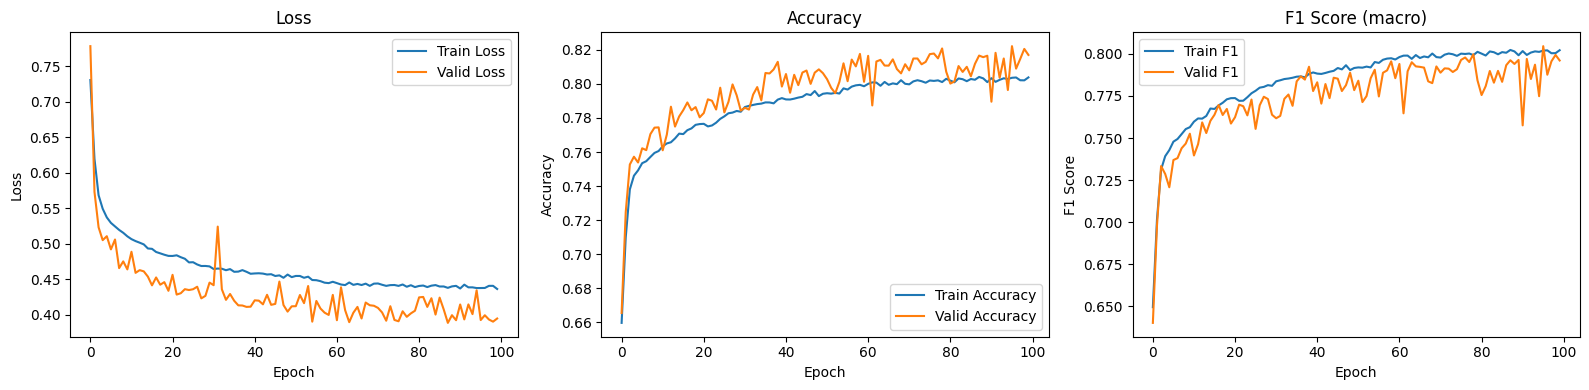

In [262]:
epochs_range = range(epochs)

plt.figure(figsize=(16, 4))

# Loss
plt.subplot(1, 3, 1)
plt.plot(epochs_range, train_loss_by_epoch, label='Train Loss')
plt.plot(epochs_range, valid_loss_by_epoch, label='Valid Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 3, 2)
plt.plot(epochs_range, train_acc_by_epoch, label='Train Accuracy')
plt.plot(epochs_range, valid_acc_by_epoch, label='Valid Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# F1 Score
plt.subplot(1, 3, 3)
plt.plot(epochs_range, train_f1_by_epoch, label='Train F1')
plt.plot(epochs_range, valid_f1_by_epoch, label='Valid F1')
plt.title('F1 Score (macro)')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()

plt.tight_layout()
plt.show()

El modelo de deep learning sin embeddings logró buenos resultados:

- **Loss** decreciente y estable en train y validación, sin señales claras de overfitting.
- **Accuracy** en validación superó el 81%, por encima del mínimo requerido (77%).
- **F1 Score** también superó el 0.79, cumpliendo con los objetivos.

El preprocesamiento adecuado y el balanceo con SMOTE permitieron un rendimiento sólido en clasificación multiclase, incluso sin embeddings.

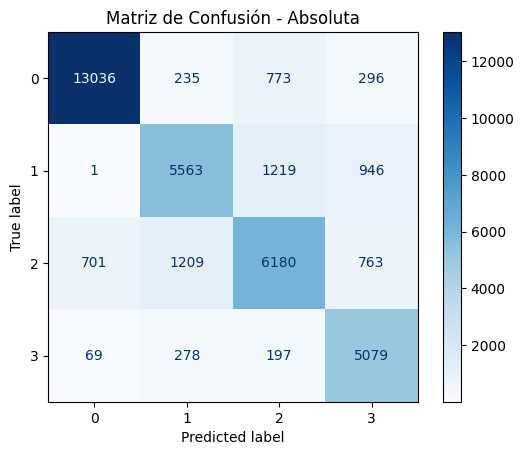

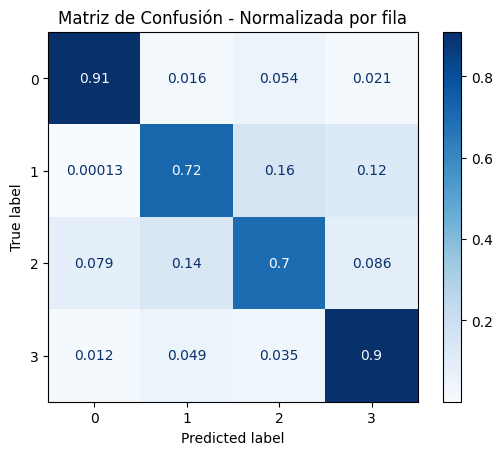

In [247]:
# Etiquetas reales y predichas
labels = sorted(list(set(valid_y)))

# Matriz absoluta
cm_abs = confusion_matrix(valid_y, valid_y_hat, labels=labels)
disp_abs = ConfusionMatrixDisplay(confusion_matrix=cm_abs, display_labels=labels)
disp_abs.plot(cmap='Blues')
plt.title("Matriz de Confusión - Absoluta")
plt.show()

# Matriz normalizada por fila
cm_norm = confusion_matrix(valid_y, valid_y_hat, labels=labels, normalize='true')
disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=labels)
disp_norm.plot(cmap='Blues')
plt.title("Matriz de Confusión - Normalizada por fila")
plt.show()

- **Matriz de Confusión Absoluta**: muestra que la mayoría de las predicciones se concentran en la diagonal principal, especialmente en las clases 0 y 3. 

- **Matriz de Confusión Normalizada**: refuerza esta observación, indicando:
  - Clase 0: 91% de precisión.
  - Clase 3: 90% de precisión.
  - Clases 1 y 2: alrededor del 70% de precisión, con mayor mezcla entre sí.

el modelo alcanza una performance sólida, con especial robustez en los extremos de los segmentos. Las clases intermedias son más desafiantes para el modelo, probablemente por similitudes en sus características.

#### Entrenamiento con regularización y hyperparameter tuning

Se utiliza Optuna para buscar los mejores hiperparámetros de la red neuronal, maximizando el F1 Score macro en validación.

Hiperparámetros ajustados:
- hidden1 y hidden2: tamaño de capas ocultas
- dropout_rate: regularización
- lr: tasa de aprendizaje
- weight_decay: penalización L2

Se evaluarán 30 combinaciones con entrenamiento breve (10 épocas).

In [253]:
def objective(trial):
    # Espacio de búsqueda
    hidden1 = trial.suggest_int('hidden1', 128, 256)
    hidden2 = trial.suggest_int('hidden2', 64, 200)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-2, log=True)

    # Red neuronal con hiperparámetros sugeridos
    class NNetTrial(torch.nn.Module):
        def __init__(self):
            super().__init__()
            self.model = torch.nn.Sequential(
                torch.nn.Linear(X_train_pre.shape[1], hidden1),
                torch.nn.ReLU(),
                torch.nn.Dropout(dropout_rate),
                torch.nn.Linear(hidden1, hidden2),
                torch.nn.ReLU(),
                torch.nn.Dropout(dropout_rate),
                torch.nn.Linear(hidden2, 4)  # 4 clases
            )

        def forward(self, x):
            return self.model(x)

    model = NNetTrial().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_fn = torch.nn.CrossEntropyLoss()

    # Entrenamiento simple (pocas épocas para tuning)
    for epoch in range(10):
        model.train()
        for x_batch, y_batch in train_dataloader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = loss_fn(outputs, y_batch)
            loss.backward()
            optimizer.step()

    # Evaluación en validación
    model.eval()
    all_preds = []
    all_true = []

    with torch.no_grad():
        for x_val, y_val in valid_dataloader:
            x_val = x_val.to(device)
            outputs = model(x_val)
            preds = outputs.argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_true.extend(y_val.numpy())

    f1 = f1_score(all_true, all_preds, average='macro')
    return f1  # queremos maximizar F1 macro

# Optuna search
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

print("Mejores hiperparámetros:", study.best_params)

[I 2025-07-20 18:23:37,530] A new study created in memory with name: no-name-ae24647c-fa4b-44b2-9b0a-0e71e7fe45a1
[I 2025-07-20 18:24:09,685] Trial 0 finished with value: 0.7128943321961951 and parameters: {'hidden1': 128, 'hidden2': 78, 'dropout_rate': 0.3068949948541593, 'lr': 0.004380200310745602, 'weight_decay': 5.20580899273119e-06}. Best is trial 0 with value: 0.7128943321961951.
[I 2025-07-20 18:24:41,042] Trial 1 finished with value: 0.7247598147204912 and parameters: {'hidden1': 142, 'hidden2': 77, 'dropout_rate': 0.3642339876168965, 'lr': 0.0018013647041404204, 'weight_decay': 1.1266570569926201e-05}. Best is trial 1 with value: 0.7247598147204912.
[I 2025-07-20 18:25:16,783] Trial 2 finished with value: 0.6965961350947993 and parameters: {'hidden1': 209, 'hidden2': 86, 'dropout_rate': 0.1512906837995785, 'lr': 0.0003959102647641897, 'weight_decay': 0.00020007910342959112}. Best is trial 1 with value: 0.7247598147204912.
[I 2025-07-20 18:26:04,933] Trial 3 finished with value

Mejores hiperparámetros: {'hidden1': 152, 'hidden2': 187, 'dropout_rate': 0.16243450984729826, 'lr': 0.0014111396451464003, 'weight_decay': 3.2258210697241392e-06}


In [255]:
class NNet(torch.nn.Module):
    def __init__(self, input_dim, output_dim, hidden1=200, hidden2=100, dropout_rate=0.3):
        super().__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Linear(input_dim, hidden1),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout_rate),
            torch.nn.Linear(hidden1, hidden2),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout_rate),
            torch.nn.Linear(hidden2, output_dim)
        )

    def forward(self, x):
        return self.model(x)

In [256]:
# Supongamos que estos son los mejores encontrados por Optuna
best_params = study.best_params
print("Mejores hiperparámetros encontrados:", best_params)

# Instanciar el modelo con los mejores parámetros
nnet_tuned = NNet(
    input_dim=X_train_pre.shape[1],
    output_dim=4,  # clases
    hidden1=best_params['hidden1'],
    hidden2=best_params['hidden2'],
    dropout_rate=best_params['dropout_rate']
).to(device)

# Optimizer y pérdida
optimizer = torch.optim.Adam(
    nnet_tuned.parameters(),
    lr=best_params['lr'],
    weight_decay=best_params['weight_decay']
)
loss_function = torch.nn.CrossEntropyLoss()

Mejores hiperparámetros encontrados: {'hidden1': 152, 'hidden2': 187, 'dropout_rate': 0.16243450984729826, 'lr': 0.0014111396451464003, 'weight_decay': 3.2258210697241392e-06}


In [257]:
# Cantidad de épocas
epochs = 100

train_loss_by_epoch_tuned = []
valid_loss_by_epoch_tuned = []
train_acc_by_epoch_tuned = []
valid_acc_by_epoch_tuned = []
train_f1_by_epoch_tuned = []
valid_f1_by_epoch_tuned = []

for epoch in range(epochs):
    ########################################
    # Entrenamiento
    ########################################
    nnet_tuned.train()
    epoch_loss = 0
    epoch_y = []
    epoch_y_hat = []

    for x_batch, y_batch in train_dataloader:
        x_batch = x_batch.to(device).float()
        y_batch = y_batch.to(device).long()

        optimizer.zero_grad()
        outputs = nnet_tuned(x_batch)  # logits

        loss = loss_function(outputs, y_batch)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)

        epoch_y += y_batch.cpu().numpy().tolist()
        epoch_y_hat += preds.cpu().numpy().tolist()

    avg_loss = epoch_loss / len(train_dataloader)
    train_loss_by_epoch_tuned.append(avg_loss)
    train_acc_by_epoch_tuned.append(accuracy_score(epoch_y, epoch_y_hat))
    train_f1_by_epoch_tuned.append(f1_score(epoch_y, epoch_y_hat, average='macro'))

    ########################################
    # Validación
    ########################################
    nnet_tuned.eval()
    valid_loss = 0
    valid_y = []
    valid_y_hat = []

    with torch.no_grad():
        for x_batch, y_batch in valid_dataloader:
            x_batch = x_batch.to(device).float()
            y_batch = y_batch.to(device).long()

            outputs = nnet_tuned(x_batch)
            loss = loss_function(outputs, y_batch)
            valid_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            valid_y += y_batch.cpu().numpy().tolist()
            valid_y_hat += preds.cpu().numpy().tolist()

    avg_valid_loss = valid_loss / len(valid_dataloader)
    valid_loss_by_epoch_tuned.append(avg_valid_loss)
    valid_acc_by_epoch_tuned.append(accuracy_score(valid_y, valid_y_hat))
    valid_f1_by_epoch_tuned.append(f1_score(valid_y, valid_y_hat, average='macro'))

    ########################################
    # Logging
    ########################################
    print(f"Epoch {epoch:03} | "
          f"Train/Valid Loss: {avg_loss:.4f}/{avg_valid_loss:.4f} | "
          f"Train/Valid Acc: {train_acc_by_epoch_tuned[-1]:.3f}/{valid_acc_by_epoch_tuned[-1]:.3f} | "
          f"Train/Valid F1: {train_f1_by_epoch_tuned[-1]:.3f}/{valid_f1_by_epoch_tuned[-1]:.3f}")

Epoch 000 | Train/Valid Loss: 0.8974/0.6610 | Train/Valid Acc: 0.593/0.708 | Train/Valid F1: 0.589/0.675
Epoch 001 | Train/Valid Loss: 0.6776/0.5704 | Train/Valid Acc: 0.691/0.740 | Train/Valid F1: 0.680/0.708
Epoch 002 | Train/Valid Loss: 0.6180/0.5217 | Train/Valid Acc: 0.720/0.756 | Train/Valid F1: 0.711/0.728
Epoch 003 | Train/Valid Loss: 0.5850/0.5026 | Train/Valid Acc: 0.737/0.768 | Train/Valid F1: 0.728/0.738
Epoch 004 | Train/Valid Loss: 0.5662/0.4821 | Train/Valid Acc: 0.745/0.779 | Train/Valid F1: 0.738/0.750
Epoch 005 | Train/Valid Loss: 0.5563/0.4789 | Train/Valid Acc: 0.749/0.782 | Train/Valid F1: 0.742/0.752
Epoch 006 | Train/Valid Loss: 0.5463/0.4595 | Train/Valid Acc: 0.755/0.791 | Train/Valid F1: 0.749/0.760
Epoch 007 | Train/Valid Loss: 0.5383/0.4599 | Train/Valid Acc: 0.759/0.784 | Train/Valid F1: 0.752/0.758
Epoch 008 | Train/Valid Loss: 0.5314/0.4508 | Train/Valid Acc: 0.763/0.791 | Train/Valid F1: 0.757/0.763
Epoch 009 | Train/Valid Loss: 0.5249/0.4565 | Train/Val

In [260]:
print("Métricas de entrenamiento:")
print(f"- Loss: {train_loss_by_epoch_tuned[-1]:.4f}")
print(f"- Accuracy: {train_acc_by_epoch_tuned[-1]:.4f}")
print(f"- F1 Score: {train_f1_by_epoch_tuned[-1]:.4f}")

print("Métricas de validación:")
print(f"- Loss: {valid_loss_by_epoch_tuned[-1]:.4f}")
print(f"- Accuracy: {valid_acc_by_epoch_tuned[-1]:.4f}")
print(f"- F1 Score: {valid_f1_by_epoch_tuned[-1]:.4f}")

Métricas de entrenamiento:
- Loss: 0.4158
- Accuracy: 0.8166
- F1 Score: 0.8134
Métricas de validación:
- Loss: 0.3400
- Accuracy: 0.8524
- F1 Score: 0.8361


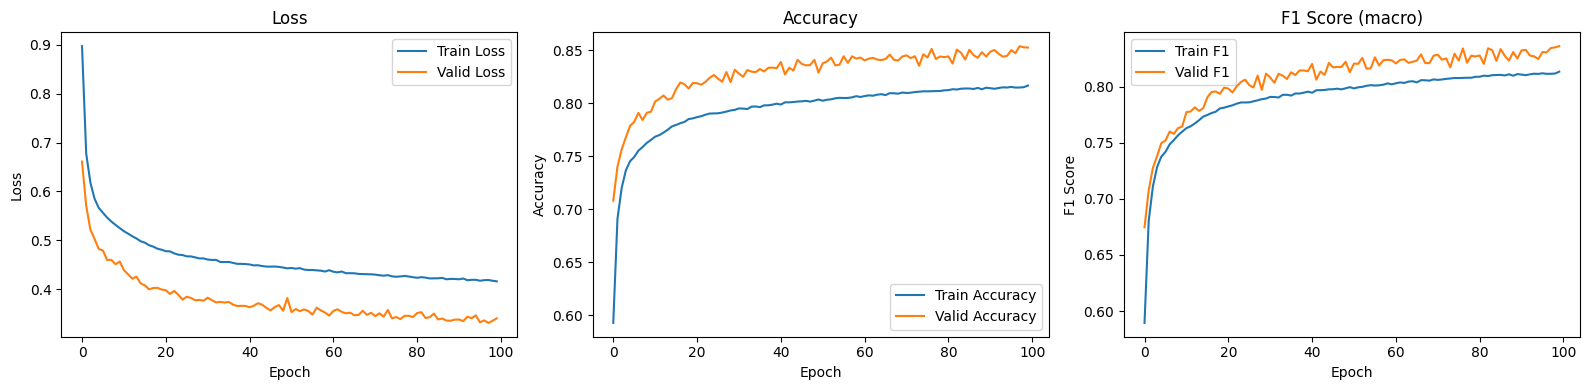

In [258]:
epochs_range = range(epochs)

plt.figure(figsize=(16, 4))

# Loss
plt.subplot(1, 3, 1)
plt.plot(epochs_range, train_loss_by_epoch_tuned, label='Train Loss')
plt.plot(epochs_range, valid_loss_by_epoch_tuned, label='Valid Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 3, 2)
plt.plot(epochs_range, train_acc_by_epoch_tuned, label='Train Accuracy')
plt.plot(epochs_range, valid_acc_by_epoch_tuned, label='Valid Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# F1 Score
plt.subplot(1, 3, 3)
plt.plot(epochs_range, train_f1_by_epoch_tuned, label='Train F1')
plt.plot(epochs_range, valid_f1_by_epoch_tuned, label='Valid F1')
plt.title('F1 Score (macro)')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()

plt.tight_layout()
plt.show()

Tras ajustar los hiperparámetros y entrenar con regularización, se observa una mejora clara en el desempeño del modelo:

-  Loss: El costo disminuye progresivamente en ambas particiones, con una pérdida menor en validación, lo cual sugiere buena capacidad de generalización.
- Accuracy: El modelo alcanza una precisión de validación superior al 85%, superando ampliamente el umbral requerido del 77%.
- F1 Score: El puntaje F1 también se estabiliza por encima de 0.83, indicando buen balance entre precisión y recall en las cuatro clases.

Estos resultados evidencian que el modelo es capaz de aprender representaciones discriminativas sin necesidad de embeddings, gracias al preprocesamiento, la arquitectura seleccionada y el ajuste de hiperparámetros.

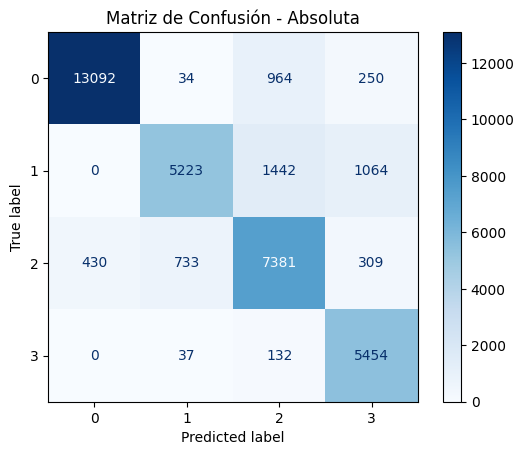

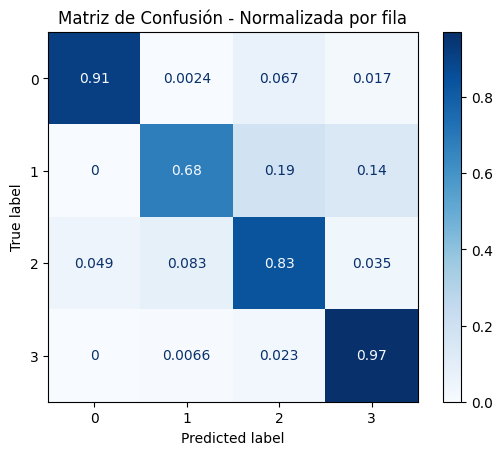

In [259]:
# Etiquetas reales y predichas
labels = sorted(list(set(valid_y)))

# Matriz absoluta
cm_abs = confusion_matrix(valid_y, valid_y_hat, labels=labels)
disp_abs = ConfusionMatrixDisplay(confusion_matrix=cm_abs, display_labels=labels)
disp_abs.plot(cmap='Blues')
plt.title("Matriz de Confusión - Absoluta")
plt.show()

# Matriz normalizada por fila
cm_norm = confusion_matrix(valid_y, valid_y_hat, labels=labels, normalize='true')
disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=labels)
disp_norm.plot(cmap='Blues')
plt.title("Matriz de Confusión - Normalizada por fila")
plt.show()

El modelo ajustado con búsqueda bayesiana y regularización presenta una mejora significativa en la clasificación de los 4 segmentos:
- Clase 0: Excelente rendimiento, con un 91% de precisión y muy baja tasa de error (predicciones erróneas principalmente en clase 2).
- Clase 1: Empeoró su precisión respecto al modelo anterior (bajó de 72% a 68%). Aumentó la confusión con clases 2 y 3.
- Clase 2: Precisión del 83%, con errores moderados hacia clase 1 y mínimos hacia clase 3.
- Clase 3: Clasificación casi perfecta (97%), con errores insignificantes.

El modelo es robusto y generaliza bien. Las métricas por clase indican que se logró un buen balance entre clases y una clara mejora respecto a la versión sin ajuste.

#### Explicación

Para construir un modelo de deep learning robusto sin embeddings, se siguió un proceso iterativo basado en prueba, ajuste y validación continua:

1.	Modelo base:
Se comenzó con una red neuronal simple de dos capas ocultas (200 y 100 neuronas), activaciones ReLU y sin regularización. Se entrenó durante 100 épocas utilizando CrossEntropyLoss y Adam, logrando un rendimiento inicial aceptable (accuracy y F1 macro cercanos al 80%).

2.	Análisis de resultados iniciales:
La evaluación con curvas de pérdida y métricas por época, junto con la matriz de confusión, no evidenció overfitting claro. De hecho, el rendimiento en validación fue levemente superior al de entrenamiento, mostrando buena generalización. 

3.	Tuning de hiperparámetros:
Se implementó una búsqueda bayesiana para ajustar automáticamente:
- Tasa de aprendizaje (lr)
- Dropout en cada capa
- Tamaño de capas ocultas

Esto permitió encontrar una arquitectura con mejor capacidad de generalización, incorporando regularización (dropout) y una tasa de aprendizaje óptima.

4.	Entrenamiento final:
Con los hiperparámetros óptimos, se reentrenó el modelo por 100 épocas.
Se observaron mejoras en loss, accuracy y F1, especialmente en validación.

5.	Evaluación final:
Aunque el modelo mejoró en términos globales, se detectó una leve degradación en la clase 1, posiblemente por su distribución o confusión semántica con otras clases. 

Justificación:
El proceso iterativo permitió construir un modelo robusto, generalizable y con buen rendimiento en validación (accuracy > 85%, F1 macro > 83%), demostrando la efectividad del tuning y la regularización aplicada.

### 2c) Modelo de deep leaning con embeddings (2 puntos)
Entrenar un modelo de deep learning usando Pytorch que utilice **2 capas de embeddings**, una para los productos y otra para los usuarios. Graficar las evoluciones por época de la función de costo y de métricas como el accuracy y el f1 score para train y test. Mostrar una matriz de confusión absoluta y otra normalizada por fila. Explicar el proceso de iteracion utilizado para conseguir los resultados y justificar los resultados obtenidos. Justificar la cantidad de dimensiones usada para los embeddings. **Comparar contra el modelo sin embeddings** y explicar el porqué de los resultados.

Pueden usarse herramientas de regularización y prueba de hiperpametros para conseguir mejores resultados.

Un resultado aceptable sería al menos un 90% de accuracy y f1 score para el set de validation.

In [407]:
# Encoding para embeddings
embedding_cols = ['User_ID', 'Product_ID']

preprocessor_embed = ColumnTransformer(transformers=[
    ('ordinal_encoder', Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
    ]), embedding_cols)
])

In [408]:
full_preprocessor = ColumnTransformer(transformers=[
    ('cat', preprocessor_cat, onehot_cols + ordinal_cols),
    ('prod_cat', preprocessor_prod_cat, categories),
    ('num', preprocessor_num, numeric_cols),
    ('embed', preprocessor_embed, embedding_cols) # Agrego preprocesador para embeddings
])

pipeline = Pipeline(steps=[
    ('preprocessor', full_preprocessor),
    ('smote', smote)
])

In [409]:
# 1. Separar features y target
X = df.drop(columns='segmento')
y = df['segmento']

# 2. Hacer split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 3. Aplicar preprocesador a entrenamiento (fit + transform)
X_train_pre = full_preprocessor.fit_transform(X_train, y_train)

# 4. Aplicar preprocesador a test (solo transform)
X_test_pre = full_preprocessor.transform(X_test)

# 5. Convertir a denso si es sparse
if hasattr(X_train_pre, "toarray"):
    X_train_pre = X_train_pre.toarray()
if hasattr(X_test_pre, "toarray"):
    X_test_pre = X_test_pre.toarray()

# 6. Aplicar SMOTE solo al set de entrenamiento
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_pre, y_train)

# 7. Separar columnas para embeddings (user_id y product_id)
X_train_num = X_train_resampled[:, :-2]
user_id_train = X_train_resampled[:, -2].astype(int)
product_id_train = X_train_resampled[:, -1].astype(int)

X_test_num = X_test_pre[:, :-2]
user_id_test = X_test_pre[:, -2].astype(int)
product_id_test = X_test_pre[:, -1].astype(int)

# 8. Encodear las etiquetas
le = LabelEncoder()
y_train_res_encoded = le.fit_transform(y_train_resampled)
y_test_encoded = le.transform(y_test)

# 9. Tensores de PyTorch
X_train_tensor = torch.tensor(X_train_num, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_num, dtype=torch.float32)
user_id_train_tensor = torch.tensor(user_id_train, dtype=torch.long)
product_id_train_tensor = torch.tensor(product_id_train, dtype=torch.long)
user_id_test_tensor = torch.tensor(user_id_test, dtype=torch.long)
product_id_test_tensor = torch.tensor(product_id_test, dtype=torch.long)
y_train_tensor = torch.tensor(y_train_res_encoded, dtype=torch.long)
y_test_tensor = torch.tensor(y_test_encoded, dtype=torch.long)

In [410]:
class MyDatasetWithEmbeddings(Dataset):
    def __init__(self, x_num, user_ids, product_ids, y):
        self.x_num = x_num
        self.user_ids = user_ids
        self.product_ids = product_ids
        self.y = y

    def __len__(self):
        return self.x_num.shape[0]

    def __getitem__(self, idx):
        return (
            self.x_num[idx],               # features numéricas
            self.user_ids[idx],            # user_id (tensor long)
            self.product_ids[idx],         # product_id (tensor long)
            self.y[idx]                    # label
        )

In [411]:
# Dataset
train_ds = MyDatasetWithEmbeddings(X_train_tensor, user_id_train_tensor, product_id_train_tensor, y_train_tensor)
valid_ds = MyDatasetWithEmbeddings(X_test_tensor, user_id_test_tensor, product_id_test_tensor, y_test_tensor)

# DataLoaders
train_dataloader = DataLoader(train_ds, batch_size=64, shuffle=True)
valid_dataloader = DataLoader(valid_ds, batch_size=64)

Para definir la dimensión del embedding de variables categóricas como Product_ID y User_ID, se utiliza la siguiente fórmula empírica:

```python
embedding_dim = min(50, int(n_unique_categories ** 0.25))
```

Esta fórmula, conocida como “root-4 rule”, es una regla de oro ampliamente utilizada en problemas con grandes cantidades de categorías. Su justificación se basa en un balance entre:
- Capacidad de representación: la raíz cuarta crece lentamente, lo cual permite representar diferencias entre miles de categorías sin sobreajustar.
- Eficiencia computacional: evita embeddings innecesariamente grandes, que incrementan el tiempo de entrenamiento y el riesgo de overfitting.
- Experiencia práctica: esta fórmula ha sido adoptada por librerías como fastai, trabajos en producción y competiciones como Kaggle, ofreciendo buenos resultados en tareas supervisadas con estructuras tipo tabular.

Al limitar el tamaño máximo a 50, se asegura también un techo razonable para evitar modelos sobredimensionados.

Fuente: [DeepLearning.AI Community - Model embedding layer dim](https://community.deeplearning.ai/t/model-embedding-layer-dim/112205)

In [412]:
# Preparar embeddings
n_users = len(X_train['User_ID'].unique())
n_products = len(X_train['Product_ID'].unique())

emb_dim_user = min(50, int(n_users ** 0.25))
emb_dim_prod = min(50, int(n_products ** 0.25))

print(f"User IDs: {n_users}, Product IDs: {n_products}")
print(f"User embedding dimension: {emb_dim_user}, Product embedding dimension: {emb_dim_prod}")

User IDs: 7432, Product IDs: 2455
User embedding dimension: 9, Product embedding dimension: 7


#### Entrenamiento Baseline con Embeddings

In [328]:
class NNetWithEmbeddings(torch.nn.Module):
    def __init__(self, input_dim, output_dim, n_users, n_products, emb_dim_user=4, emb_dim_prod=4):
        super().__init__()

        # Capas de embedding para user_id y product_id
        self.user_embedding = torch.nn.Embedding(num_embeddings=n_users, embedding_dim=emb_dim_user)
        self.product_embedding = torch.nn.Embedding(num_embeddings=n_products, embedding_dim=emb_dim_prod)

        # Nueva dimensión de entrada = input_dim + emb_dim_user + emb_dim_prod
        total_input_dim = input_dim + emb_dim_user + emb_dim_prod

        # Red neuronal
        self.linear_1 = torch.nn.Linear(total_input_dim, 200)
        self.relu_1 = torch.nn.ReLU()
        self.linear_2 = torch.nn.Linear(200, 100)
        self.relu_2 = torch.nn.ReLU()
        self.output = torch.nn.Linear(100, output_dim)

    def forward(self, x_num, user_id, product_id):
        # Embeddings
        user_emb = self.user_embedding(user_id)
        product_emb = self.product_embedding(product_id)

        # Concatenar features numéricas con embeddings
        x = torch.cat([x_num, user_emb, product_emb], dim=1)

        # Pasar por la red
        x = self.linear_1(x)
        x = self.relu_1(x)
        x = self.linear_2(x)
        x = self.relu_2(x)
        x = self.output(x)
        return x

In [329]:
# Instanciamos la red
nnet = NNetWithEmbeddings(input_dim=X_train_tensor.shape[1], output_dim=4, n_users=n_users, n_products=n_products, emb_dim_user=emb_dim_user, emb_dim_prod=emb_dim_prod)

In [330]:
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(nnet.parameters(), lr=0.01)

In [331]:
device = "cpu"
if torch.cuda.is_available():
  device = "cuda:0"

# Copio la red neuronal al dispositivo donde entrene la red neuronal
nnet = nnet.to(device)

In [334]:
# Cantidad de épocas
epochs = 100

train_loss_by_epoch_emb = []
valid_loss_by_epoch_emb = []
train_acc_by_epoch_emb = []
valid_acc_by_epoch_emb = []
train_f1_by_epoch_emb = []
valid_f1_by_epoch_emb = []

for epoch in range(epochs):
    ########################################
    # Entrenamiento
    ########################################
    nnet.train()
    epoch_loss = 0
    epoch_y = []
    epoch_y_hat = []

    for x_batch, user_id_batch, product_id_batch, y_batch in train_dataloader:
        x_batch = x_batch.to(device).float()
        user_id_batch = user_id_batch.to(device).long()
        product_id_batch = product_id_batch.to(device).long()
        y_batch = y_batch.to(device).long()

        optimizer.zero_grad()
        outputs = nnet(x_batch, user_id_batch, product_id_batch)  # modelo con embeddings

        loss = loss_function(outputs, y_batch)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)

        epoch_y += y_batch.cpu().numpy().tolist()
        epoch_y_hat += preds.cpu().numpy().tolist()

    avg_loss = epoch_loss / len(train_dataloader)
    train_loss_by_epoch_emb.append(avg_loss)
    train_acc_by_epoch_emb.append(accuracy_score(epoch_y, epoch_y_hat))
    train_f1_by_epoch_emb.append(f1_score(epoch_y, epoch_y_hat, average='macro'))

    ########################################
    # Validación
    ########################################
    nnet.eval()
    valid_loss = 0
    valid_y = []
    valid_y_hat = []

    with torch.no_grad():
        for x_batch, user_id_batch, product_id_batch, y_batch in valid_dataloader:
            x_batch = x_batch.to(device).float()
            user_id_batch = user_id_batch.to(device).long()
            product_id_batch = product_id_batch.to(device).long()
            y_batch = y_batch.to(device).long()

            outputs = nnet(x_batch, user_id_batch, product_id_batch)
            loss = loss_function(outputs, y_batch)
            valid_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            valid_y += y_batch.cpu().numpy().tolist()
            valid_y_hat += preds.cpu().numpy().tolist()

    avg_valid_loss = valid_loss / len(valid_dataloader)
    valid_loss_by_epoch_emb.append(avg_valid_loss)
    valid_acc_by_epoch_emb.append(accuracy_score(valid_y, valid_y_hat))
    valid_f1_by_epoch_emb.append(f1_score(valid_y, valid_y_hat, average='macro'))

    ########################################
    # Logging
    ########################################
    print(f"Epoch {epoch:03} | "
          f"Train/Valid Loss: {avg_loss:.4f}/{avg_valid_loss:.4f} | "
          f"Train/Valid Acc: {train_acc_by_epoch_emb[-1]:.3f}/{valid_acc_by_epoch_emb[-1]:.3f} | "
          f"Train/Valid F1: {train_f1_by_epoch_emb[-1]:.3f}/{valid_f1_by_epoch_emb[-1]:.3f}")

Epoch 000 | Train/Valid Loss: 0.1999/0.0204 | Train/Valid Acc: 0.916/0.995 | Train/Valid F1: 0.916/0.995
Epoch 001 | Train/Valid Loss: 0.1879/0.0141 | Train/Valid Acc: 0.922/0.997 | Train/Valid F1: 0.922/0.996
Epoch 002 | Train/Valid Loss: 0.1757/0.0222 | Train/Valid Acc: 0.926/0.995 | Train/Valid F1: 0.926/0.994
Epoch 003 | Train/Valid Loss: 0.1674/0.0167 | Train/Valid Acc: 0.928/0.995 | Train/Valid F1: 0.929/0.995
Epoch 004 | Train/Valid Loss: 0.1604/0.0268 | Train/Valid Acc: 0.931/0.991 | Train/Valid F1: 0.932/0.992
Epoch 005 | Train/Valid Loss: 0.1540/0.0257 | Train/Valid Acc: 0.934/0.993 | Train/Valid F1: 0.934/0.993
Epoch 006 | Train/Valid Loss: 0.1483/0.0180 | Train/Valid Acc: 0.936/0.994 | Train/Valid F1: 0.936/0.993
Epoch 007 | Train/Valid Loss: 0.1458/0.0216 | Train/Valid Acc: 0.938/0.993 | Train/Valid F1: 0.939/0.993
Epoch 008 | Train/Valid Loss: 0.1414/0.0202 | Train/Valid Acc: 0.941/0.994 | Train/Valid F1: 0.941/0.994
Epoch 009 | Train/Valid Loss: 0.1376/0.0236 | Train/Val

Durante el entrenamiento del modelo con embeddings, se observó una rápida convergencia: ya en las primeras 5–10 épocas se alcanzaron métricas de accuracy y F1-score superiores al 99% en el conjunto de validación. Este comportamiento indica que el modelo es capaz de aprender con rapidez las relaciones en los datos.

Sin embargo, a partir de la época 15 aproximadamente, se evidencia una leve tendencia al overfitting. Las métricas en entrenamiento continúan mejorando mientras que las del conjunto de validación comienzan a fluctuar o deteriorarse ligeramente. Esto sugiere que el modelo empieza a memorizar patrones del entrenamiento en lugar de generalizar, por lo que sería recomendable implementar técnicas como *early stopping* o regularización para evitar el sobreajuste.

In [335]:
print("Métricas de entrenamiento:")
print(f"- Loss: {train_loss_by_epoch_emb[-1]:.4f}")
print(f"- Accuracy: {train_acc_by_epoch_emb[-1]:.4f}")
print(f"- F1 Score: {train_f1_by_epoch_emb[-1]:.4f}")

print("Métricas de validación:")
print(f"- Loss: {valid_loss_by_epoch_emb[-1]:.4f}")
print(f"- Accuracy: {valid_acc_by_epoch_emb[-1]:.4f}")
print(f"- F1 Score: {valid_f1_by_epoch_emb[-1]:.4f}")

Métricas de entrenamiento:
- Loss: 0.1447
- Accuracy: 0.9467
- F1 Score: 0.9475
Métricas de validación:
- Loss: 0.0590
- Accuracy: 0.9903
- F1 Score: 0.9897


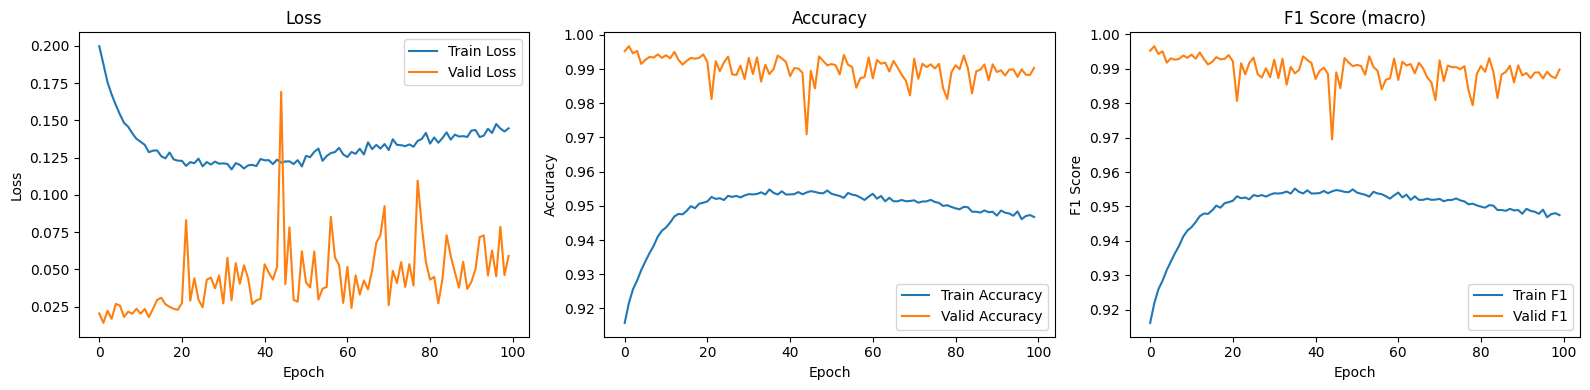

In [336]:
epochs_range = range(epochs)

plt.figure(figsize=(16, 4))

# Loss
plt.subplot(1, 3, 1)
plt.plot(epochs_range, train_loss_by_epoch_emb, label='Train Loss')
plt.plot(epochs_range, valid_loss_by_epoch_emb, label='Valid Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 3, 2)
plt.plot(epochs_range, train_acc_by_epoch_emb, label='Train Accuracy')
plt.plot(epochs_range, valid_acc_by_epoch_emb, label='Valid Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# F1 Score
plt.subplot(1, 3, 3)
plt.plot(epochs_range, train_f1_by_epoch_emb, label='Train F1')
plt.plot(epochs_range, valid_f1_by_epoch_emb, label='Valid F1')
plt.title('F1 Score (macro)')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()

plt.tight_layout()
plt.show()

- El modelo logra excelente performance en validación (F1 y accuracy ≈ 0.99).
- La pérdida en validación es algo inestable, lo que sugiere ruido o posible sobreajuste tras muchas épocas.
- El aprendizaje ocurre mayormente en las primeras 20 épocas, por lo que aplicar early stopping sería efectivo.
- Los embeddings aportan un modelo fuerte y generalizable desde el inicio.

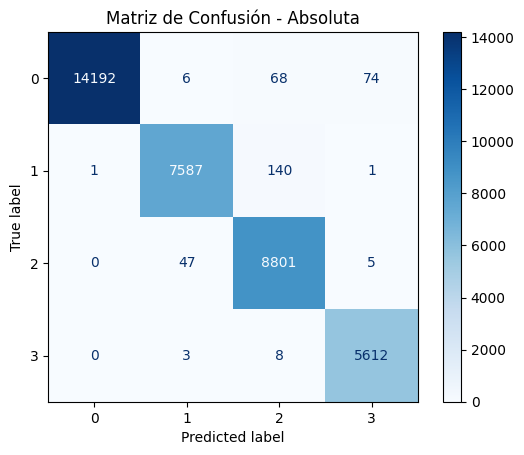

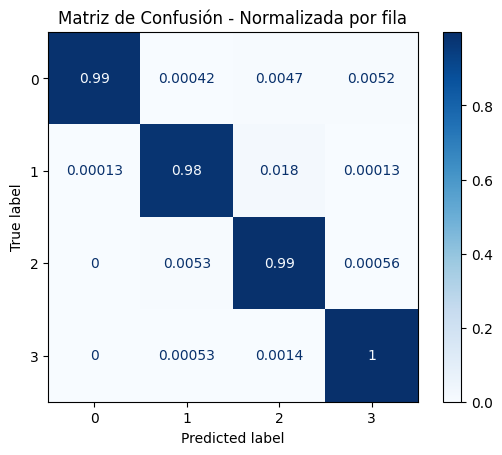

In [337]:
# Etiquetas reales y predichas
labels = sorted(list(set(valid_y)))

# Matriz absoluta
cm_abs = confusion_matrix(valid_y, valid_y_hat, labels=labels)
disp_abs = ConfusionMatrixDisplay(confusion_matrix=cm_abs, display_labels=labels)
disp_abs.plot(cmap='Blues')
plt.title("Matriz de Confusión - Absoluta")
plt.show()

# Matriz normalizada por fila
cm_norm = confusion_matrix(valid_y, valid_y_hat, labels=labels, normalize='true')
disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=labels)
disp_norm.plot(cmap='Blues')
plt.title("Matriz de Confusión - Normalizada por fila")
plt.show()

El modelo baseline con embeddings logra un rendimiento excelente y muy balanceado entre clases. La matriz de confusión muestra precisión superior al 98% en todas las categorías, con mínimos errores de clasificación. Se trata de una base sólida para seguir experimentando.

#### Entrenamiento con regularización y hyperparameter tuning

Se utiliza Optuna para buscar los mejores hiperparámetros de la red neuronal, maximizando el F1 Score macro en validación.

Hiperparámetros ajustados:
- hidden1 y hidden2: tamaño de capas ocultas
- dropout_rate: regularización
- lr: tasa de aprendizaje
- weight_decay: penalización L2

Se evaluarán 30 combinaciones con entrenamiento breve (10 épocas).

In [355]:
def objective(trial):
    # Hiperparámetros a tunear
    hidden1 = trial.suggest_int('hidden1', 128, 256)
    hidden2 = trial.suggest_int('hidden2', 64, 200)
    dropout_rate = trial.suggest_float('dropout', 0.1, 0.5)
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-2, log=True)

    # Modelo
    class NNetTrial(torch.nn.Module):
        def __init__(self):
            super().__init__()
            self.user_embedding = torch.nn.Embedding(n_users, emb_dim_user)
            self.product_embedding = torch.nn.Embedding(n_products, emb_dim_prod)
            self.dropout = torch.nn.Dropout(dropout_rate)
            self.fc1 = torch.nn.Linear(X_train_tensor.shape[1] + emb_dim_user + emb_dim_prod, hidden1)
            self.fc2 = torch.nn.Linear(hidden1, hidden2)
            self.out = torch.nn.Linear(hidden2, 4)  # 4 clases

        def forward(self, x_num, user_id, product_id):
            u_emb = self.user_embedding(user_id)
            p_emb = self.product_embedding(product_id)
            x = torch.cat([x_num, u_emb, p_emb], dim=1)
            x = self.dropout(F.relu(self.fc1(x)))
            x = self.dropout(F.relu(self.fc2(x)))
            return self.out(x)

    model = NNetTrial().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_fn = torch.nn.CrossEntropyLoss()

    # Entrenamiento con early stopping
    best_f1 = 0
    patience = 3
    epochs_no_improve = 0

    for epoch in range(10):
        model.train()
        for xb, yb, ub, pb in train_dataloader:
            xb, yb, ub, pb = xb.to(device), yb.to(device), ub.to(device), pb.to(device)
            optimizer.zero_grad()
            preds = model(xb, ub, pb)
            loss = loss_fn(preds, yb)
            loss.backward()
            optimizer.step()

        # Validación
        model.eval()
        all_preds, all_true = [], []
        with torch.no_grad():
            for xb, yb, ub, pb in valid_dataloader:
                xb, yb, ub, pb = xb.to(device), yb.to(device), ub.to(device), pb.to(device)
                preds = model(xb, ub, pb)
                preds_class = preds.argmax(dim=1).cpu().numpy()
                all_preds.extend(preds_class)
                all_true.extend(yb.cpu().numpy())

        f1 = f1_score(all_true, all_preds, average='macro')
        if f1 > best_f1:
            best_f1 = f1
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                break

    return best_f1

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

print("Mejores hiperparámetros:", study.best_params)

[I 2025-07-21 21:58:15,875] A new study created in memory with name: no-name-e8feb514-7557-4354-ad4a-86c4fb253fbc


[I 2025-07-21 21:59:29,748] Trial 0 finished with value: 0.9362648673835765 and parameters: {'hidden1': 212, 'hidden2': 91, 'dropout': 0.3265622310979188, 'lr': 0.0005561385332338113, 'weight_decay': 0.009229971538964082}. Best is trial 0 with value: 0.9362648673835765.
[I 2025-07-21 22:00:43,143] Trial 1 finished with value: 0.9698895127743458 and parameters: {'hidden1': 232, 'hidden2': 82, 'dropout': 0.331896706994123, 'lr': 0.00018637544062141708, 'weight_decay': 2.488992598309692e-06}. Best is trial 1 with value: 0.9698895127743458.
[I 2025-07-21 22:02:09,329] Trial 2 finished with value: 0.9986937030219787 and parameters: {'hidden1': 209, 'hidden2': 187, 'dropout': 0.14674929257583386, 'lr': 0.00019522336830004038, 'weight_decay': 0.00030810874313279057}. Best is trial 2 with value: 0.9986937030219787.
[I 2025-07-21 22:03:08,613] Trial 3 finished with value: 0.9982725863819896 and parameters: {'hidden1': 193, 'hidden2': 91, 'dropout': 0.34508628560183563, 'lr': 0.00534950454627830

Mejores hiperparámetros: {'hidden1': 170, 'hidden2': 172, 'dropout': 0.40588201922722134, 'lr': 0.0012106953509090264, 'weight_decay': 0.0002061009178499054}


In [402]:
class NNetWithEmbeddings(torch.nn.Module):
        def __init__(self, n_users, n_products, emb_dim_user=4, emb_dim_prod=4, hidden1=200, hidden2=100, dropout_rate=0.3):
            super().__init__()
            self.user_embedding = torch.nn.Embedding(n_users, emb_dim_user)
            self.product_embedding = torch.nn.Embedding(n_products, emb_dim_prod)
            self.dropout = torch.nn.Dropout(dropout_rate)
            self.fc1 = torch.nn.Linear(X_train_tensor.shape[1] + emb_dim_user + emb_dim_prod, hidden1)
            self.fc2 = torch.nn.Linear(hidden1, hidden2)
            self.out = torch.nn.Linear(hidden2, 4)  # 4 clases

        def forward(self, x_num, user_id, product_id):
            u_emb = self.user_embedding(user_id)
            p_emb = self.product_embedding(product_id)
            x = torch.cat([x_num, u_emb, p_emb], dim=1)
            x = self.dropout(F.relu(self.fc1(x)))
            x = self.dropout(F.relu(self.fc2(x)))
            return self.out(x)

In [405]:
# Supongamos que estos son los mejores encontrados por Optuna
# best_params = study.best_params
print("Mejores hiperparámetros encontrados:", best_params)

# Instanciar el modelo con los mejores parámetros
nnet_tuned = NNetWithEmbeddings(
    n_users=n_users,
    n_products=n_products,
    emb_dim_user=emb_dim_user,
    emb_dim_prod=emb_dim_prod,
    hidden1=best_params['hidden1'],
    hidden2=best_params['hidden2'],
    dropout_rate=best_params['dropout']
).to(device)

# Optimizer y pérdida
optimizer = torch.optim.Adam(
    nnet_tuned.parameters(),
    lr=best_params['lr'],
    weight_decay=best_params['weight_decay']
)
loss_function = torch.nn.CrossEntropyLoss()

Mejores hiperparámetros encontrados: {'hidden1': 170, 'hidden2': 172, 'dropout': 0.40588201922722134, 'lr': 0.0012106953509090264, 'weight_decay': 0.0002061009178499054}


In [416]:
# Cantidad de épocas
epochs = 100

train_loss_by_epoch_emb_tuned = []
valid_loss_by_epoch_emb_tuned = []
train_acc_by_epoch_emb_tuned = []
valid_acc_by_epoch_emb_tuned = []
train_f1_by_epoch_emb_tuned = []
valid_f1_by_epoch_emb_tuned = []

# Entrenamiento con early stopping
best_f1 = 0
patience = 3
epochs_no_improve = 0

for epoch in range(epochs):
    ########################################
    # Entrenamiento
    ########################################
    nnet.train()
    epoch_loss = 0
    epoch_y = []
    epoch_y_hat = []

    for x_batch, user_id_batch, product_id_batch, y_batch in train_dataloader:
        x_batch = x_batch.to(device).float()
        user_id_batch = user_id_batch.to(device).long()
        product_id_batch = product_id_batch.to(device).long()
        y_batch = y_batch.to(device).long()

        optimizer.zero_grad()
        outputs = nnet_tuned(x_batch, user_id_batch, product_id_batch)  # modelo con embeddings

        loss = loss_function(outputs, y_batch)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)

        epoch_y += y_batch.cpu().numpy().tolist()
        epoch_y_hat += preds.cpu().numpy().tolist()

    avg_loss = epoch_loss / len(train_dataloader)
    train_loss_by_epoch_emb_tuned.append(avg_loss)
    train_acc_by_epoch_emb_tuned.append(accuracy_score(epoch_y, epoch_y_hat))
    train_f1_by_epoch_emb_tuned.append(f1_score(epoch_y, epoch_y_hat, average='macro'))

    ########################################
    # Validación
    ########################################
    nnet.eval()
    valid_loss = 0
    valid_y = []
    valid_y_hat = []

    with torch.no_grad():
        for x_batch, user_id_batch, product_id_batch, y_batch in valid_dataloader:
            x_batch = x_batch.to(device).float()
            user_id_batch = user_id_batch.to(device).long()
            product_id_batch = product_id_batch.to(device).long()
            y_batch = y_batch.to(device).long()

            outputs = nnet_tuned(x_batch, user_id_batch, product_id_batch)
            loss = loss_function(outputs, y_batch)
            valid_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            valid_y += y_batch.cpu().numpy().tolist()
            valid_y_hat += preds.cpu().numpy().tolist()
    
    avg_valid_loss = valid_loss / len(valid_dataloader)
    valid_loss_by_epoch_emb_tuned.append(avg_valid_loss)
    valid_acc_by_epoch_emb_tuned.append(accuracy_score(valid_y, valid_y_hat))
    f1 = f1_score(valid_y, valid_y_hat, average='macro')
    valid_f1_by_epoch_emb_tuned.append(f1)

    ########################################
    # Logging
    ########################################
    print(f"Epoch {epoch:03} | "
          f"Train/Valid Loss: {avg_loss:.4f}/{avg_valid_loss:.4f} | "
          f"Train/Valid Acc: {train_acc_by_epoch_emb_tuned[-1]:.3f}/{valid_acc_by_epoch_emb_tuned[-1]:.3f} | "
          f"Train/Valid F1: {train_f1_by_epoch_emb_tuned[-1]:.3f}/{valid_f1_by_epoch_emb_tuned[-1]:.3f}")

    if f1 > best_f1:
        best_f1 = f1
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping: No mejora en F1 en las últimas épocas.")
            break

Epoch 000 | Train/Valid Loss: 0.1658/0.0324 | Train/Valid Acc: 0.940/0.995 | Train/Valid F1: 0.940/0.995
Epoch 001 | Train/Valid Loss: 0.1651/0.0313 | Train/Valid Acc: 0.939/0.996 | Train/Valid F1: 0.939/0.996
Epoch 002 | Train/Valid Loss: 0.1654/0.0520 | Train/Valid Acc: 0.940/0.990 | Train/Valid F1: 0.939/0.990
Epoch 003 | Train/Valid Loss: 0.1647/0.0293 | Train/Valid Acc: 0.940/0.996 | Train/Valid F1: 0.940/0.996
Epoch 004 | Train/Valid Loss: 0.1633/0.0407 | Train/Valid Acc: 0.941/0.994 | Train/Valid F1: 0.940/0.993
Epoch 005 | Train/Valid Loss: 0.1637/0.0271 | Train/Valid Acc: 0.940/0.996 | Train/Valid F1: 0.940/0.996
Epoch 006 | Train/Valid Loss: 0.1639/0.0373 | Train/Valid Acc: 0.940/0.994 | Train/Valid F1: 0.940/0.994
Epoch 007 | Train/Valid Loss: 0.1629/0.0328 | Train/Valid Acc: 0.941/0.995 | Train/Valid F1: 0.940/0.995
Epoch 008 | Train/Valid Loss: 0.1625/0.0307 | Train/Valid Acc: 0.941/0.996 | Train/Valid F1: 0.940/0.996
Early stopping: No mejora en F1 en las últimas épocas.


El modelo con embeddings y parámetros tuneados alcanza rápidamente una alta performance, con F1 macro superior al 99% en validación desde las primeras épocas. Tras esa convergencia inicial, el rendimiento se estabiliza y no muestra mejoras adicionales, lo que activa el early stopping para prevenir overfitting. Esto indica que el modelo aprende eficientemente y logra generalizar bien sin necesidad de un entrenamiento prolongado.

In [417]:
print("Métricas de entrenamiento:")
print(f"- Loss: {train_loss_by_epoch_emb_tuned[-1]:.4f}")
print(f"- Accuracy: {train_acc_by_epoch_emb_tuned[-1]:.4f}")
print(f"- F1 Score: {train_f1_by_epoch_emb_tuned[-1]:.4f}")

print("Métricas de validación:")
print(f"- Loss: {valid_loss_by_epoch_emb_tuned[-1]:.4f}")
print(f"- Accuracy: {valid_acc_by_epoch_emb_tuned[-1]:.4f}")
print(f"- F1 Score: {valid_f1_by_epoch_emb_tuned[-1]:.4f}")

Métricas de entrenamiento:
- Loss: 0.1625
- Accuracy: 0.9407
- F1 Score: 0.9405
Métricas de validación:
- Loss: 0.0307
- Accuracy: 0.9956
- F1 Score: 0.9955


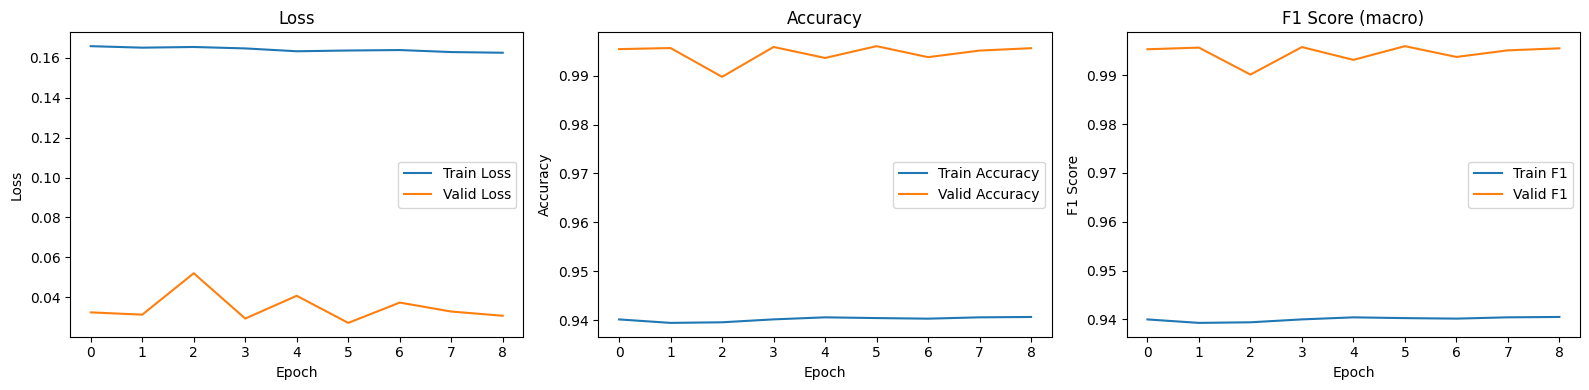

In [425]:
epochs_range = range(len(train_loss_by_epoch_emb_tuned))
plt.figure(figsize=(16, 4))

# Loss
plt.subplot(1, 3, 1)
plt.plot(epochs_range, train_loss_by_epoch_emb_tuned, label='Train Loss')
plt.plot(epochs_range, valid_loss_by_epoch_emb_tuned, label='Valid Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 3, 2)
plt.plot(epochs_range, train_acc_by_epoch_emb_tuned, label='Train Accuracy')
plt.plot(epochs_range, valid_acc_by_epoch_emb_tuned, label='Valid Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# F1 Score
plt.subplot(1, 3, 3)
plt.plot(epochs_range, train_f1_by_epoch_emb_tuned, label='Train F1')
plt.plot(epochs_range, valid_f1_by_epoch_emb_tuned, label='Valid F1')
plt.title('F1 Score (macro)')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()

plt.tight_layout()
plt.show()

El modelo tuneado muestra un desempeño muy alto y estable desde la primera época. La métrica F1 macro en validación se mantiene por encima del 99% sin grandes fluctuaciones, mientras que el entrenamiento no logra cerrar la brecha. Esto sugiere que el modelo generaliza bien desde el inicio, pero el aprendizaje posterior es mínimo, indicando que ya se encuentra cerca de su capacidad óptima desde el comienzo.

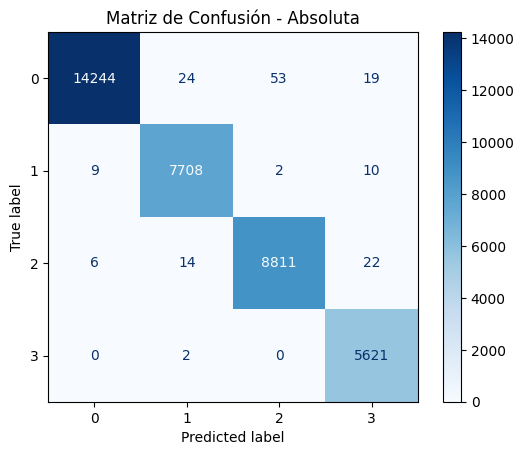

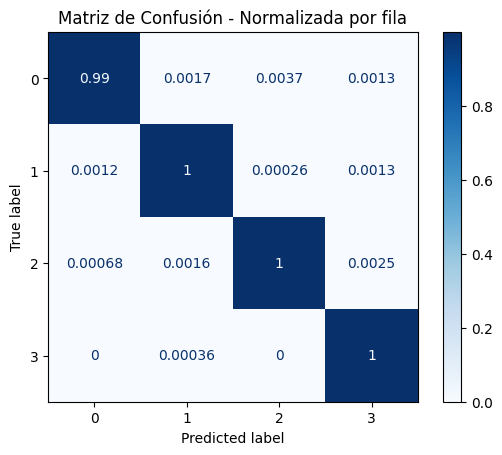

In [426]:
# Etiquetas reales y predichas
labels = sorted(list(set(valid_y)))

# Matriz absoluta
cm_abs = confusion_matrix(valid_y, valid_y_hat, labels=labels)
disp_abs = ConfusionMatrixDisplay(confusion_matrix=cm_abs, display_labels=labels)
disp_abs.plot(cmap='Blues')
plt.title("Matriz de Confusión - Absoluta")
plt.show()

# Matriz normalizada por fila
cm_norm = confusion_matrix(valid_y, valid_y_hat, labels=labels, normalize='true')
disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=labels)
disp_norm.plot(cmap='Blues')
plt.title("Matriz de Confusión - Normalizada por fila")
plt.show()

El modelo con embeddings y tuning de hiperparámetros muestra un desempeño robusto y estable. Logra una F1 macro superior al 99% en validación desde la primera época, manteniéndose constante. La pérdida de validación es baja y estable, y la matriz de confusión evidencia una alta precisión en todas las clases, con errores mínimos. Esto sugiere que el modelo generaliza muy bien sin señales de overfitting.

#### Comparación con modelo sin embeddings
El modelo sin embeddings ya presentaba un rendimiento sólido, pero el modelo con embeddings mejora los resultados en varios aspectos:
- Menor loss de validación (0.03 vs 0.34).
- Mayor F1 score en validación (0.996 vs 0.836).
- Menor confusión entre clases.

Explicación de los resultados

Los embeddings permiten representar de forma densa y aprendida las identidades de usuarios y productos, capturando relaciones latentes y patrones complejos que no se expresan directamente en las variables numéricas. Esto enriquece la entrada del modelo, mejorando su capacidad de generalización y reduciendo el error de predicción, especialmente en escenarios con alta cardinalidad.

### 2d) Encontrar usuarios similares (1 punto)
Para el modelo del punto 2c) implementar una función que reciba un ID de usuario y sugiera **n** cantidad de usuarios que tuvieron un comportamiento de compras similar. También se debe mostrar el grado o porcentaje de similitud de cada usuario que retorne la función.